# Imports & Modules

In [7]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports

tqdm.pandas()
import yaml
import json

# Figures imports
import matplotlib
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string


## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

pvalues_cutoff = json.load(open('config/config_files.json'))['pvalues_cutoff']
pvalues_cutoff = [[e, str(e)] for e in pvalues_cutoff]

import matplotlib.font_manager as font_manager

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Load files

# Enrichment into changing category genes

In [8]:
# Compute Nb of Unique exons

def overlaps(ranges):
    ranges = sorted(ranges)  # If our inputs are garunteed sorted, we can skip this
    it = iter(ranges)
    try:
        curr_start, curr_stop = next(it)
        # overlaps = False  # If we want to exclude output ranges not produced by overlapping input ranges
    except StopIteration:
        return
    for start, stop in it:
        if curr_start <= start <= curr_stop:  # Assumes intervals are closed
            curr_stop = max(curr_stop, stop)
            # overlaps = True
        else:
            # if overlaps:
            yield curr_start, curr_stop
            curr_start, curr_stop = start, stop
            # overlaps = False
    # if overlaps:
    yield curr_start, curr_stop

def overlap_apply(df):
    r = df.drop_duplicates(subset=['ranges'])
    r = r.ranges.tolist()
    r = [(int(e.split('-')[0]), int(e.split('-')[1])) for e in r]
    df['Unique_nb'] = len(list(overlaps(r)))
    return df


## Homo sapiens

### Update with count & write file

In [6]:
# H sapiens

hs_genes = pd.read_parquet("/gstock/GeneIso/V2/Genes.parquet")
hs_mrna = pd.read_parquet("/gstock/GeneIso/V2/mRNA.parquet")
hs_exons = pd.read_parquet("/gstock/GeneIso/V2/Exons.parquet")
hs_exons['ranges'] = hs_exons['Exon region start (bp)'].astype(str) + '-' + hs_exons['Exon region end (bp)'].astype(str)

hs_cds = pd.read_parquet("/gstock/GeneIso/V2/CDS.parquet")
hs_cds['ranges'] = hs_cds['Exon region start (bp)'].astype(str) + '-' + hs_cds['Exon region end (bp)'].astype(str)

# TODO 
hs_cds = hs_cds.groupby('GeneID').progress_apply(overlap_apply)
hs_cds.to_parquet("/gstock/GeneIso/V2/CDS_update.parquet")
hs_exons = hs_exons.groupby('GeneID').progress_apply(overlap_apply)
hs_exons.to_parquet("/gstock/GeneIso/V2/Exons_update.parquet")

hs_five_UTR = pd.read_parquet("/gstock/GeneIso/V2/5_UTR.parquet")
hs_three_UTR = pd.read_parquet("/gstock/GeneIso/V2/3_UTR.parquet")
#TODO
hs_five_UTR['ranges']  = hs_five_UTR["5' UTR start"].astype(int).astype(str) + '-' +  hs_five_UTR["5' UTR start"].astype(int).astype(str)
hs_three_UTR['ranges'] = hs_three_UTR["3' UTR start"].astype(int).astype(str) + '-' + hs_three_UTR["3' UTR start"].astype(int).astype(str)
hs_five_UTR = hs_five_UTR.groupby('GeneID').progress_apply(overlap_apply)
hs_five_UTR.to_parquet("/gstock/GeneIso/V2/5_UTR_update.parquet")

hs_three_UTR = hs_three_UTR.groupby('GeneID').progress_apply(overlap_apply)
hs_three_UTR.to_parquet("/gstock/GeneIso/V2/3_UTR_update.parquet")

hs_introns = pd.read_parquet("/gstock/GeneIso/V2/Introns.parquet")
hs_introns.loc[hs_introns['Strand'] == 1, 'Ordinal_nb_inverted'] = hs_introns.loc[hs_introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1

## Mus Musculus

In [5]:
genes = pd.read_parquet("/gstock/GeneIso/V2/Genes_MM.parquet")
# mrna = pd.read_parquet("/gstock/GeneIso/V2/mRNA.parquet")
exons = pd.read_parquet("/gstock/GeneIso/V2/Exons_MM.parquet")
exons['ranges'] = exons['Exon region start (bp)'].astype(str) + '-' + exons['Exon region end (bp)'].astype(str)


cds = pd.read_parquet("/gstock/GeneIso/V2/CDS_MM.parquet")
cds['ranges'] = cds['Exon region start (bp)'].astype(str) + '-' + cds['Exon region end (bp)'].astype(str)

# TODO 
cds = cds.groupby('GeneID').progress_apply(overlap_apply)
exons = exons.groupby('GeneID').progress_apply(overlap_apply)

cds.to_parquet("/gstock/GeneIso/V2/CDS_update_MM.parquet")
exons.to_parquet("/gstock/GeneIso/V2/Exons_update_MM.parquet")


five_UTR = pd.read_parquet("/gstock/GeneIso/V2/5_UTR_MM.parquet")
three_UTR = pd.read_parquet("/gstock/GeneIso/V2/3_UTR_MM.parquet")
introns = pd.read_parquet("/gstock/GeneIso/V2/Introns_MM.parquet")

# TODO 
five_UTR['ranges'] = five_UTR['UTR_start'].astype(int).astype(str) + '-' + five_UTR['UTR_end'].astype(int).astype(str)
three_UTR['ranges'] = three_UTR['UTR_start'].astype(int).astype(str) + '-' + three_UTR['UTR_end'].astype(int).astype(str)
five_UTR = five_UTR.groupby('GeneID').progress_apply(overlap_apply)
three_UTR = three_UTR.groupby('GeneID').progress_apply(overlap_apply)

five_UTR.to_parquet("/gstock/GeneIso/V2/5_UTR_update_MM.parquet")
three_UTR.to_parquet("/gstock/GeneIso/V2/3_UTR_update_MM.parquet")




#TODO
# introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] = introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1

# Descritive stats

## Genes

In [30]:
genes_new = genes[['Miso_siso', 'GeneID', 'Gene name', 'ensembl_gene_id', 'chromosome_name', 'start_position', 'end_position']].drop_duplicates()
genes_new['Gene_length'] = genes_new['end_position'] - genes_new['start_position']

In [132]:
describe = pd.concat(
    [
        hs_genes.groupby('Miso_siso')['Gene_length'].describe().round(0).astype(int),
        genes_new.groupby('Miso_siso')['Gene_length'].describe().round(0).astype(int),
    ],
    axis=0
)
describe.index = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

count   mean     std  min    25%    50%    75%      max
HS MISOG   9826  82044  143420  704  15084  36574  89612  2473538
   SISOG   3675  51655   90223  489   9536  23037  56162  1899593
MM MISOG   8933  66287  130727  616  11958  27996  67630  2960898
   SISOG   3221  43801   83590  566   8437  19336  45084  2058378

## mRNA

In [45]:
mrna = genes[['Miso_siso', 'GeneID', 'Gene name', 'ensembl_gene_id', 'ensembl_transcript_id', 'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length']].drop_duplicates()

In [44]:
mrna_describe = pd.concat(
    [
        hs_mrna.groupby('Miso_siso')['Transcript length (including UTRs and CDS)'].describe().round(0).astype(int).T,
        mrna.groupby('Miso_siso')['transcript_length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
mrna_describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
mrna_describe

HS             MM       
       MISOG  SISOG   MISOG  SISOG
count  31111   3675   22589   5314
mean    3070   3728    3145   3116
std     2361   2772    2337   2297
min      267    303     132    215
25%     1537   1805    1652   1577
50%     2424   2979    2673   2578
75%     3925   4865    4058   3961
max    34626  30609  123179  24060

## Exons

### Length

In [70]:
hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
hs_exons = hs_exons.loc[hs_exons['Length'] > 0]

exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
exons = exons.loc[exons['Length'] > 0]

describe = pd.concat(
    [
        hs_exons.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
        exons.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS             MM       
        MISOG  SISOG   MISOG  SISOG
count  183827  36173  137283  37128
mean      409    378     338    364
std       922    962     789    777
min         1      2       1      2
25%        95     97      94     99
50%       145    137     137    144
75%       269    203     220    229
max     33289  27302  122801  20715

### Nb

In [134]:
hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
hs_exons = hs_exons.loc[hs_exons['Length'] > 0]

exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
exons = exons.loc[exons['Length'] > 0]

describe = pd.concat(
    [
        hs_exons.groupby(['Miso_siso', 'GeneID'])['Exon region start (bp)'].nunique().groupby('Miso_siso').describe().round(0).astype(int).T,
        exons.groupby(['Miso_siso', 'GeneID'])['Exon region start (bp)'].nunique().groupby('Miso_siso').describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS          MM      
      MISOG SISOG MISOG SISOG
count  9826  3675  8933  3221
mean     16    10    14    11
std      11    10    10    10
min       2     2     1     1
25%       9     4     7     5
50%      13     7    12     8
75%      20    12    18    14
max     161   107   149   109

## CDS

In [71]:
hs_cds = hs_cds.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
hs_cds = hs_cds.loc[hs_cds['Length'] > 0]

cds = cds.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
cds = cds.loc[cds['Length'] > 0]

describe = pd.concat(
    [
        hs_cds.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
        cds.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS             MM       
        MISOG  SISOG   MISOG  SISOG
count  161242  34776  125843  35075
mean      167    179     162    180
std       273    315     245    283
min         1      1       1      1
25%        77     89      81     88
50%       117    127     119    127
75%       168    174     167    176
max     17330  15792   16625   9658

## Introns length

In [72]:
hs_introns = hs_introns.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Introns'])
hs_introns = hs_introns.loc[hs_introns['Length'] > 0]

introns = introns.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Introns'])
introns = introns.loc[introns['Length'] > 0]

describe = pd.concat(
    [
        hs_introns.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
        introns.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS               MM        
         MISOG   SISOG    MISOG   SISOG
count   142425   32498   114998   31460
mean      7703    5005     5872    4428
std      23815   14920    22222   14027
min          1       1        1       1
25%        581     458      482     420
50%       1818    1424     1442    1275
75%       5433    3807     3780    3211
max    1160410  654925  2908815  536970

## Introns length according ordinal

In [126]:
hs_introns = pd.read_parquet("/gstock/GeneIso/V2/Introns.parquet")
hs_introns.loc[hs_introns['Strand'] == 1, 'Ordinal_nb_inverted'] = hs_introns.loc[hs_introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1
hs_introns = hs_introns.loc[hs_introns['Ordinal_nb'] <= 5] 

introns = pd.read_parquet("/gstock/GeneIso/V2/Introns_MM.parquet")
introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] = introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1
introns = introns.loc[introns['Ordinal_nb'] <= 5] 

pd.concat(
    [
        hs_introns.groupby(['Miso_siso', 'Ordinal_nb'])['Length'].describe().round(0).astype(int),
        introns.groupby(['Miso_siso', 'Ordinal_nb'])['Length'].describe().round(0).astype(int)

    ], axis=0
).T

Miso_siso     Miso                                       Siso                  \
Ordinal_nb     1.0      2.0     3.0      4.0      5.0     1.0     2.0     3.0   
count        43680    42115   39113    35472    31887    3675    3213    2854   
mean         15887    11778    8735     6539     5543   13167    8010    5541   
std          35141    31602   25903    20442    18006   29571   22329   14515   
min             29        0       1        0        0       1      68      67   
25%            987      802     642      579      525    1053     659     536   
50%           3998     2561    2070     1760     1643    3755    2046    1616   
75%          15422     8326    6174     4778     4227   12537    5777    4386   
max         956395  1160410  772518  1096452  1047317  654925  367620  253993   

Miso_siso                     Miso                                     Siso  \
Ordinal_nb     4.0     5.0     1.0      2.0     3.0     4.0     5.0     1.0   
count         2532    2244   22506    21827   20503   18884   17276    5275   
mean          4339    3735   16394    10488    7634    5518    4659   11075   
std          10874    8569   40173    35478   25013   17065   16075   26212   
min              1      69       1        0       4       0       0      29   
25%            464     390    1000      727     569     523     457     918   
50%           1434    1368    3896     2303    1755    1548    1393    3157   
75%           3696    3490   14785     7098    4847    3851    3422   10344   
max         222578  130369  940551  2908815  785804  551318  551318  536970   

Miso_siso                                   
Ordinal_nb     2.0     3.0     4.0     5.0  
count         4719    4232    3753    3317  
mean          7016    4772    3712    3331  
std          19838   12658   10007    8451  
min              0       3       0      64  
25%            635     502     432     381  
50%           1813    1478    1257    1274  
75%           4687    3718    3113    2853  
max         362814  171562  224742  141021

## 5' UTR length

In [73]:
hs_five_UTR = hs_five_UTR.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)'])
hs_five_UTR = hs_five_UTR.loc[hs_five_UTR['Length'] > 0]

five_UTR = five_UTR.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)'])
five_UTR = five_UTR.loc[five_UTR['Length'] > 0]

describe = pd.concat(
    [
        hs_five_UTR.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
        five_UTR.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS           MM      
       MISOG SISOG  MISOG SISOG
count  53935  4816  27771  6633
mean     156   143    154   166
std      221   169    192   227
min        1     1      1     1
25%       51    42     51    54
50%      100    92    104   108
75%      184   178    192   205
max     6565  2222   8961  7606

## 3' UTR length

In [74]:
hs_three_UTR = hs_three_UTR.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)'])
hs_three_UTR = hs_three_UTR.loc[hs_three_UTR['Length'] > 0]

three_UTR = three_UTR.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)'])
three_UTR = three_UTR.loc[three_UTR['Length'] > 0]

describe = pd.concat(
    [
        three_UTR.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
        three_UTR.groupby('Miso_siso')['Length'].describe().round(0).astype(int).T,
    ],
    axis=1
)
describe.columns = pd.MultiIndex.from_product([['HS', 'MM'], ['MISOG', 'SISOG']])
describe

HS             MM       
        MISOG  SISOG   MISOG  SISOG
count   20869   5546   20869   5546
mean     1070   1130    1070   1130
std      1579   1411    1579   1411
min         1      1       1      1
25%       201    202     201    202
50%       594    592     594    592
75%      1455   1567    1455   1567
max    122582  18864  122582  18864

# MISOG SISOG category comparison for HS & MM

In [8]:
new_count = genes.groupby('ensembl_gene_id')['ensembl_transcript_id'].nunique().rename('transcript_count_mm').reset_index()
new_count.loc[new_count['transcript_count_mm'] > 1, 'Miso_siso_mm'] = 'Miso'
new_count.loc[new_count['transcript_count_mm'] == 1, 'Miso_siso_mm'] = 'Siso'
new_count = pd.merge(genes, new_count,on='ensembl_gene_id')[['GeneID', 'ensembl_gene_id', 'Miso_siso', 'Miso_siso_mm']].drop_duplicates()
# new_count.groupby('Miso_siso')['Miso_siso_mm'].value_counts()
new_count['Miso_siso_full'] = 'HS:' + new_count['Miso_siso'] + '-MM:' + new_count['Miso_siso_mm']
new_count

,GeneID,ensembl_gene_id,Miso_siso,Miso_siso_mm,Miso_siso_full
0,ENSG00000000003,ENSMUSG00000067377,Miso,Siso,HS:Miso-MM:Siso
1,ENSG00000000005,ENSMUSG00000031250,Siso,Siso,HS:Siso-MM:Siso
2,ENSG00000000419,ENSMUSG00000078919,Miso,Miso,HS:Miso-MM:Miso
4,ENSG00000000457,ENSMUSG00000026584,Miso,Miso,HS:Miso-MM:Miso
7,ENSG00000000460,ENSMUSG00000041406,Miso,Miso,HS:Miso-MM:Miso
...,...,...,...,...,...
27895,ENSG00000284194,ENSMUSG00000091780,Miso,Miso,HS:Miso-MM:Miso
27897,ENSG00000284308,ENSMUSG00000030030,Miso,Miso,HS:Miso-MM:Miso
27899,ENSG00000284753,ENSMUSG00000115219,Siso,Miso,HS:Siso-MM:Miso
27901,ENSG00000284770,ENSMUSG00000039233,Miso,Siso,HS:Miso-MM:Siso


## Custom panel figure

In [547]:
def custom_figure(hs_five_UTR_new, hs_three_UTR_new, hs_exons_new, hs_cds_new, hs_introns_new, hs_genes_new, hs_mrna_new, palette, title, alpha=1):

    def show_values_on_bars(axs):
        def _show_on_single_plot(ax):        
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if np.isnan(p.get_height()) == False and p.get_height() > 0.4:
                    value = '{:0}'.format(int(p.get_height()))
                    ax.text(_x, _y, value, ha="center", fontsize=12) 

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

    def median_boxplot_label(ax, data, x, y):
        labels = sorted(data[x].unique().tolist())
        medians = data.groupby([x])[y].median()
        vertical_offset = data[y].median() * 0.05 # offset from median for display

        for xtick in ax.get_xticks():
            ax.text(xtick, medians[labels[xtick]] + vertical_offset, round(medians[labels[xtick]]), horizontalalignment='center',size='x-small',color='black',weight='semibold')            

#     palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
    bw = 0.25
    cut = 0.05
    lw = 0


    fig = plt.figure(figsize=(20, 27)) 
    gs = matplotlib.gridspec.GridSpec(7, 2, width_ratios=[1, 1]) 
    
    ax50 = plt.subplot(gs[0,0])
    ax51 = plt.subplot(gs[0,1])
    ax10 = plt.subplot(gs[1,0])
    ax11 = plt.subplot(gs[1,1])
    ax40 = plt.subplot(gs[2,0])
    ax41 = plt.subplot(gs[2,1])    
    ax20 = plt.subplot(gs[3,0])
    ax21 = plt.subplot(gs[3,1])    
    ax30 = plt.subplot(gs[4,0])
    ax31 = plt.subplot(gs[4,1])      
    ax00 = plt.subplot(gs[5,0])
    ax01 = plt.subplot(gs[5,1])
    ax3  = plt.subplot(gs[6,0:])

    sns.boxplot(data=hs_genes_new.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Gene_length', palette=palette, linewidth=3, ax=ax50, )
    ax50.set_ylim(0,1e5)
    ax50.set_ylabel("Length")
    ax50.set_xlabel("Gene length")    
    median_boxplot_label(ax50, hs_genes_new, 'Miso_siso', 'Gene_length')    


    sns.boxplot(data=hs_mrna_new.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Transcript length (including UTRs and CDS)', palette=palette, linewidth=3, ax=ax51, )
    ax51.set_ylim(0,1e4)
    ax51.set_ylabel("Length")
    ax51.set_xlabel("Transcript length (including UTRs and CDS)")   
    median_boxplot_label(ax51, hs_mrna_new, 'Miso_siso', 'Transcript length (including UTRs and CDS)')    
    
    count_exons = hs_exons_new.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique().rename('exons_count').reset_index()
    count_exons['Miso_siso'] = count_exons['Miso_siso'].astype(str) 
    sns.boxplot(data=count_exons.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='exons_count', palette=palette, linewidth=3, ax=ax10, )
    ax10.set_ylim(0,30)
    ax10.set_ylabel("Nb")
    ax10.set_xlabel("Exons unique event")
    median_boxplot_label(ax10, count_exons, 'Miso_siso', 'exons_count')    

    
    count_cds = hs_cds_new.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique().rename('CDS_count').reset_index()
    count_cds['Miso_siso'] = count_cds['Miso_siso'].astype(str) 
    sns.boxplot(data=count_cds.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='CDS_count', palette=palette, linewidth=3, ax=ax11, )
    ax11.set_ylim(0,30)
    ax11.set_ylabel("Nb")
    ax11.set_xlabel("CDS unique event")    
    median_boxplot_label(ax11, count_cds, 'Miso_siso', 'CDS_count')    

    sns.boxplot(data=hs_exons_new[['GeneID', 'Miso_siso', 'Unique_nb']].drop_duplicates().sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Unique_nb', palette=palette, linewidth=3, ax=ax40, )
    ax40.set_ylim(0,20)
    ax40.set_xlabel("Complete unique exons range")
    ax40.set_ylabel("Nb")
    median_boxplot_label(ax40, hs_exons_new[['GeneID', 'Miso_siso', 'Unique_nb']].drop_duplicates(), 'Miso_siso', 'Unique_nb')    
    
    
    sns.boxplot(data=hs_cds_new[['GeneID', 'Miso_siso', 'Unique_nb']].drop_duplicates().sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Unique_nb', palette=palette, linewidth=3, ax=ax41, )
    ax41.set_ylim(0,20)
    ax41.set_xlabel("Complete unique CDS range")
    ax41.set_ylabel("Nb")
    median_boxplot_label(ax41, hs_cds_new[['GeneID', 'Miso_siso', 'Unique_nb']].drop_duplicates(), 'Miso_siso', 'Unique_nb')    
    
    
    sns.boxplot(data=hs_exons_new.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Length', palette=palette, linewidth=3, ax=ax20,)
    ax20.set_ylim(0,500)
    ax20.set_xlabel("Exons length")
    median_boxplot_label(ax20, hs_exons_new, 'Miso_siso', 'Length')    

    
    sns.boxplot(data=hs_cds_new.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Length', palette=palette, linewidth=3, ax=ax21,)
    ax21.set_ylim(0,500)
    ax21.set_xlabel("CDS length")
    median_boxplot_label(ax21, hs_cds_new, 'Miso_siso', 'Length')    


    sns.boxplot(data=hs_introns_new.sort_values(by=['Miso_siso'], ascending=True), x='Miso_siso', y='Length', palette=palette, linewidth=3, ax=ax30, )
    ax30.set_ylim(0,1e4)
    ax30.set_xlabel("Intron length")
    median_boxplot_label(ax30, hs_introns_new, 'Miso_siso', 'Length')    

    
    hs_introns_new_plot = hs_introns_new.loc[hs_introns_new['Ordinal_nb'] <= 3]
    sns.boxplot(data=hs_introns_new_plot.sort_values(by=['Miso_siso'], ascending=True), x='Ordinal_nb', y='Length', hue='Miso_siso', palette=palette, linewidth=3, ax=ax31, )
    ax31.set_ylim(0,1e4)
    ax31.set_xlabel("Intron length according ordinal")

    


    data_5_prime = 100 * ( hs_five_UTR_new.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts() / hs_five_UTR_new.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts().groupby('Miso_siso').sum())
    data_5_prime = data_5_prime.rename('count').reset_index()
    data_5_prime = data_5_prime.loc[data_5_prime["5' UTR start"] <= 7]
    data_5_prime = data_5_prime.round()
    data_3_prime = 100 * ( hs_three_UTR_new.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts() / hs_three_UTR_new.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts().groupby('Miso_siso').sum())
    data_3_prime = data_3_prime.rename('count').reset_index()
    data_3_prime = data_3_prime.loc[data_3_prime["3' UTR start"] <= 7]
    data_3_prime = data_3_prime.round()


    sns.barplot(data=data_5_prime, x="5' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax00)
    sns.barplot(data=data_3_prime, x="3' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax01)


    show_values_on_bars(ax00)
    show_values_on_bars(ax01)


    ax00.set_ylim(ymax=100)
    ax01.set_ylim(ymax=105)
    ax00.set_ylabel("% of transcripts")
    ax00.set_xlabel("Nb of 5' UTR exons")
    ax01.set_ylabel("% of transcripts")
    ax01.set_xlabel("Nb of 3' UTR exons")
    # ax00.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])
    labels = ["{} ({})".format(k, v) for k,v in hs_five_UTR_new.groupby('Miso_siso').GeneID.nunique().to_dict().items()]
    ax01.legend(loc='upper right', handles =  [mpatches.Patch(color=e) for e in list(sns.color_palette(palette))[:len(labels)]], labels=labels)

    ax10.legend().remove()
    ax11.legend().remove()
    ax00.legend().remove()
    ax20.legend().remove()
    ax21.legend().remove()
    ax30.legend().remove()
    ax31.legend().remove()

    l_axes = [ax10, ax11, ax20, ax21, ax30, ax31, ax40, ax41,ax50, ax51, ax00, ax01, ax3]



    distance_tss_start_strand_positive = (hs_cds_new.loc[hs_cds_new['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - hs_exons_new.loc[hs_exons_new['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
    distance_tss_start_strand_negative = (hs_exons_new.loc[hs_exons_new['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - hs_cds_new.loc[hs_cds_new['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
    tss_start = pd.concat([distance_tss_start_strand_positive, distance_tss_start_strand_negative]).rename('Length').reset_index()
    tss_start['Distance_START_STOP'] = 'START'

    distance_tts_stop_strand_positive = (hs_exons_new.loc[hs_exons_new['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - hs_cds_new.loc[hs_cds_new['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
    distance_tts_stop_strand_negative = (hs_cds_new.loc[hs_cds_new['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - hs_exons_new.loc[hs_exons_new['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
    tts_stop = pd.concat([distance_tts_stop_strand_positive, distance_tts_stop_strand_negative]).rename('Length').reset_index()
    tts_stop['Distance_START_STOP'] = 'STOP'

    tss_tts_final_df = pd.concat([tss_start, tts_stop])

    t = hs_cds_new[['GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'CDS_start_abs', 'CDS_end_abs']].drop_duplicates().groupby('GeneID')['CDS_start_abs'].count()

    tss_tts_final_df = tss_tts_final_df.loc[~tss_tts_final_df['GeneID'].isin(t[t == 1].index.tolist())]


    data = tss_tts_final_df.rename({'Distance_START_STOP' : 'variable', 'Length' : 'value'}, axis=1)




    x, y, hue = 'variable', 'value', 'Miso_siso'
#     print(data.groupby(['Miso_siso', 'variable'])['value'].describe())

    # box =sns.violinplot(data=data, x='variable', y='value', hue='Miso_siso', showfliers=True, palette='Paired', ax=ax3, bw=bw, cut=cut, linewidth=lw)
    box =sns.boxplot(data=data, x='variable', y='value', hue='Miso_siso', showfliers=True, palette=palette, ax=ax3, linewidth=3)
    plt.setp(box.collections, alpha=.3)



    ax3.set_xticklabels(["5' Distance TSS ↔ START", "3' STOP ↔ TTS"])
    ax3.set_ylabel('Length')
    ax3.set_xlabel('')
    ax3.legend().remove()
    box_pairs = [
        (('START', 'Miso'), ('START', 'Siso')),
        (('STOP', 'Miso'), ('STOP', 'Siso')),
    ]
    ax3.set_ylim(0,0.25e5)

    # add_stat_annotation(ax3, data=data, x='variable', y='value', hue='Miso_siso', box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff, fontsize=12,)
    # ax.text(-0.1, 1.15, string.ascii_uppercase[i], transform=ax3.transAxes, size=25, weight='bold')



    for ax in l_axes:
        ax.grid(axis='y')
        ax.set_axisbelow(True)

    fig.subplots_adjust(top=0.9)
        
    plt.suptitle(title, y=1.02)
        
    plt.tight_layout()
    
        
    
    return fig

# figure_path = base_dir + yaml['Figures']['Fig2']
# fig.savefig(figure_path, dpi=600)


### HS genes according nb of transcripts

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


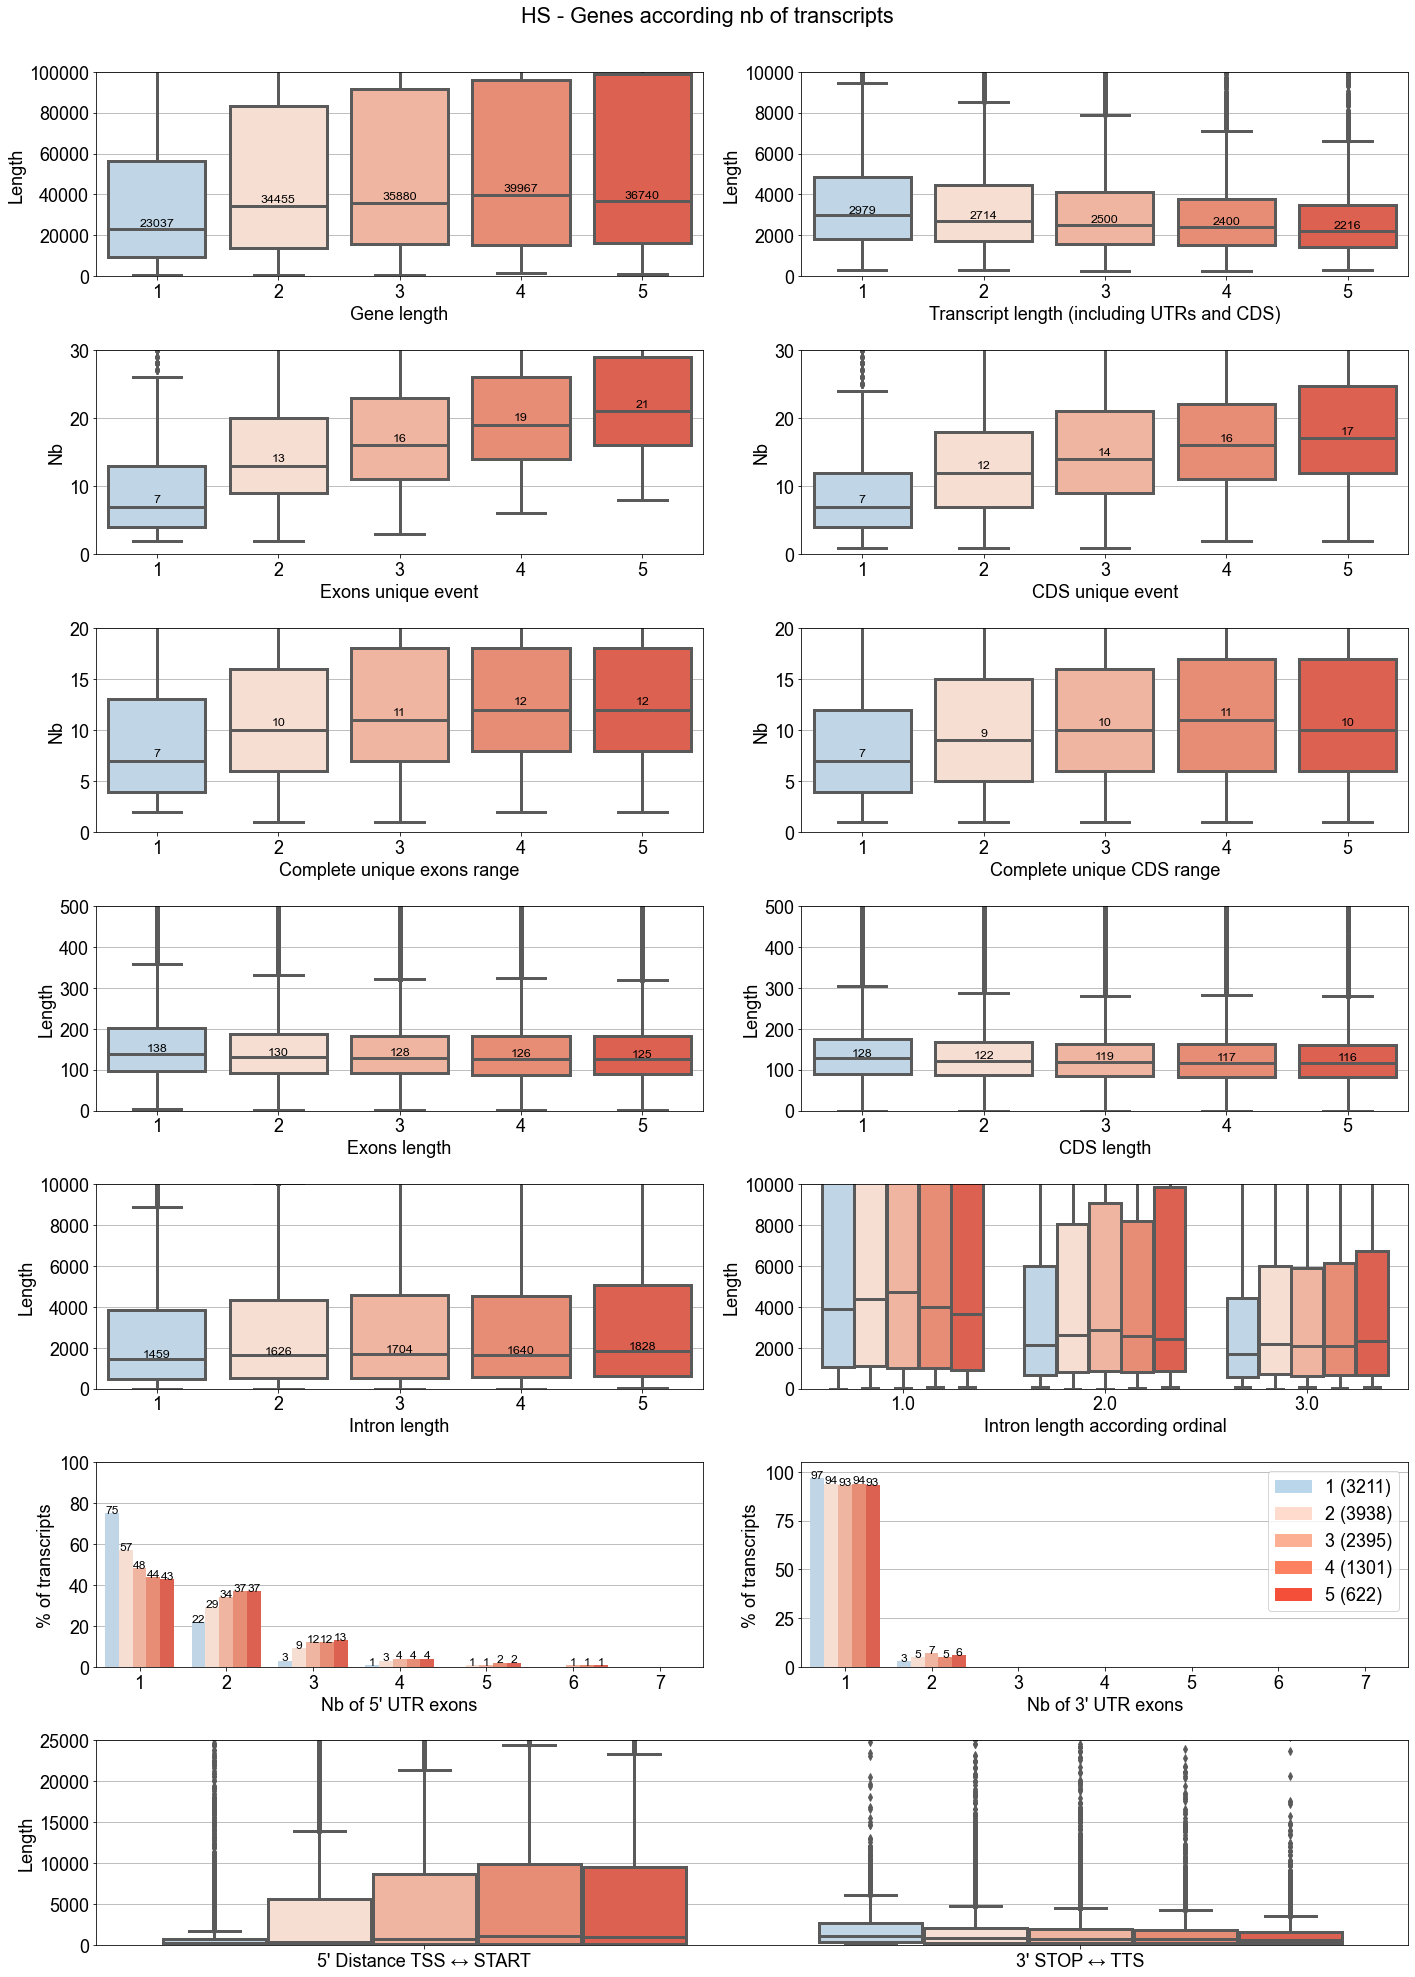

In [542]:
hs_genes_new = hs_genes.drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_mrna_new = hs_mrna.drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)

hs_five_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_five_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_three_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_three_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_exons_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_exons, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_cds_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_cds, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_introns_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_introns, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)


hs_five_UTR_new = hs_five_UTR_new.loc[(hs_five_UTR_new['Miso_siso'] <= 5)]
hs_three_UTR_new = hs_three_UTR_new.loc[(hs_three_UTR_new['Miso_siso'] <= 5)]
hs_exons_new = hs_exons_new.loc[(hs_exons_new['Miso_siso'] <= 5)]
hs_cds_new = hs_cds_new.loc[(hs_cds_new['Miso_siso'] <= 5)]
hs_introns_new = hs_introns_new.loc[(hs_introns_new['Miso_siso'] <= 5)]
hs_genes_new = hs_genes_new.loc[(hs_genes_new['Miso_siso'] <= 5)]
hs_mrna_new = hs_mrna_new.loc[(hs_mrna_new['Miso_siso'] <= 5)]


# hs_cds_new = hs_cds_new.groupby('GeneID').progress_apply(overlap_apply)
# hs_exons_new = hs_exons_new.groupby('GeneID').progress_apply(overlap_apply)

palette=sns.color_palette('Blues')[1:2] + sns.color_palette('Reds')[:4]
f = custom_figure(hs_five_UTR_new, hs_three_UTR_new, hs_exons_new, hs_cds_new, hs_introns_new, hs_genes_new, hs_mrna_new, palette=palette, title='HS - Genes according nb of transcripts')
f.savefig('/gstock/GeneIso/V2/Figures/HS_tr_count_box.png', dpi=300)

## HS x MM genes according nb of transcripts

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


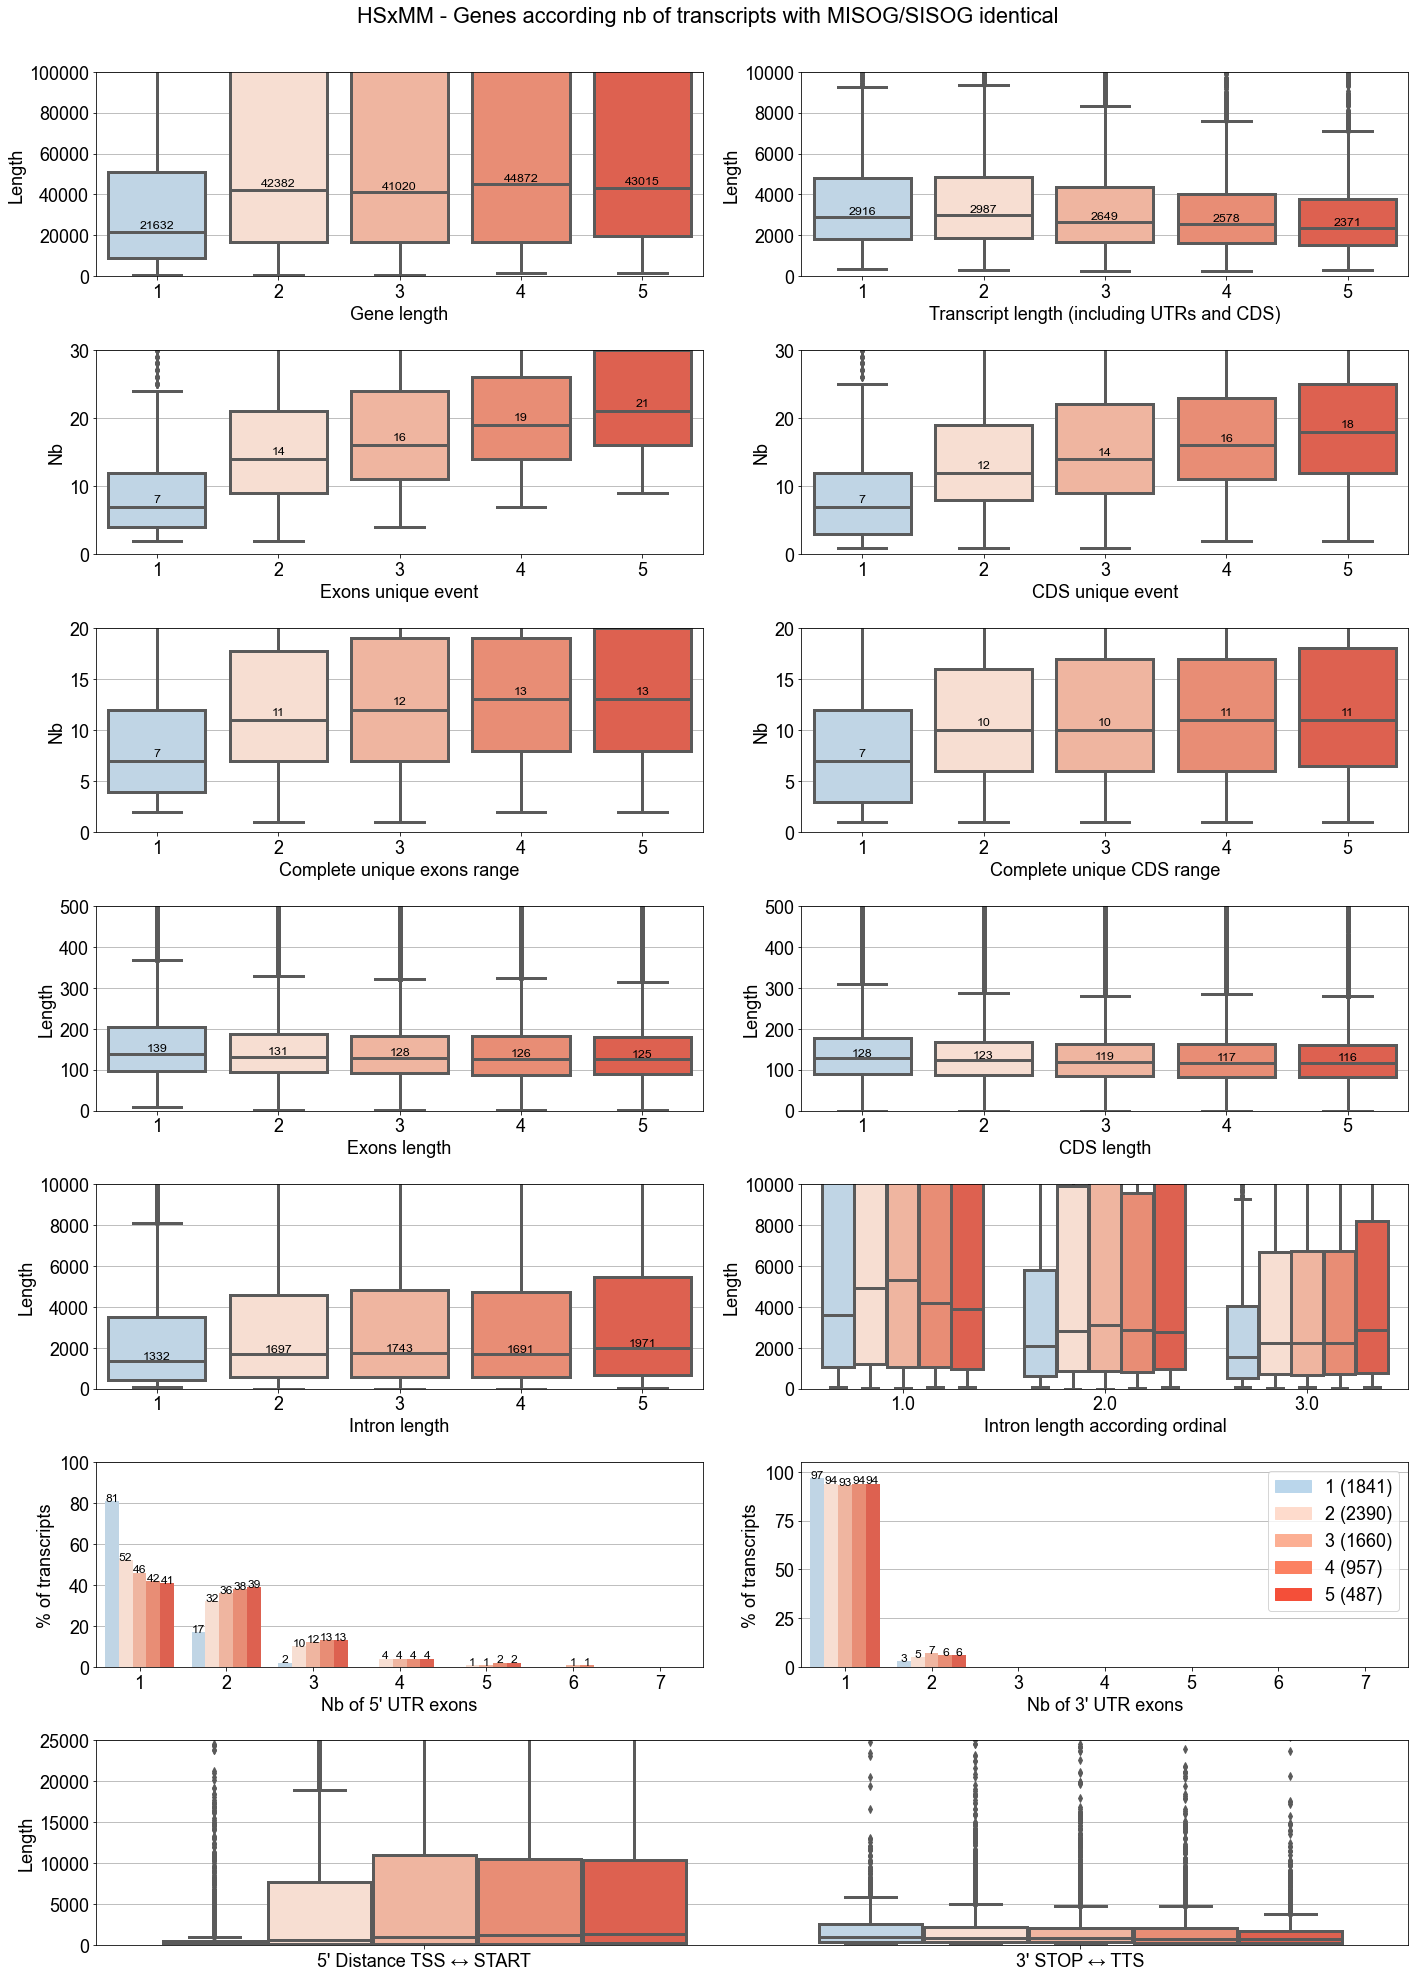

In [543]:
hs_genes_new = pd.merge( hs_genes.drop(['Miso_siso'], axis=1), new_count.drop(['Miso_siso'], axis=1), on='GeneID').rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_mrna_new = pd.merge( hs_mrna.drop(['Miso_siso'], axis=1), new_count.drop(['Miso_siso'], axis=1), on='GeneID').rename({'transcript_count' : 'Miso_siso'}, axis=1)


hs_five_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_five_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_three_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_three_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_exons_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_exons, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_cds_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_cds, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)
hs_introns_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_introns, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'transcript_count' : 'Miso_siso'}, axis=1)


hs_five_UTR_new = hs_five_UTR_new.loc[(hs_five_UTR_new['Miso_siso'] <= 5) & (hs_five_UTR_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_three_UTR_new = hs_three_UTR_new.loc[(hs_three_UTR_new['Miso_siso'] <= 5) & (hs_three_UTR_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_exons_new = hs_exons_new.loc[(hs_exons_new['Miso_siso'] <= 5) & (hs_exons_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_cds_new = hs_cds_new.loc[(hs_cds_new['Miso_siso'] <= 5) & (hs_cds_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_genes_new = hs_genes_new.loc[(hs_genes_new['Miso_siso'] <= 5) & (hs_genes_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_mrna_new = hs_mrna_new.loc[(hs_mrna_new['Miso_siso'] <= 5) & (hs_mrna_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]
hs_introns_new = hs_introns_new.loc[(hs_introns_new['Miso_siso'] <= 5) & (hs_introns_new['Miso_siso_full'].isin(['HS:Miso-MM:Miso', 'HS:Siso-MM:Siso']))]

palette=sns.color_palette('Blues')[1:2] + sns.color_palette('Reds')[:4]

# hs_cds_new = hs_cds_new.groupby('GeneID').progress_apply(overlap_apply)
# hs_exons_new = hs_exons_new.groupby('GeneID').progress_apply(overlap_apply)

f = custom_figure(hs_five_UTR_new, hs_three_UTR_new, hs_exons_new, hs_cds_new, hs_introns_new, hs_genes_new, hs_mrna_new, palette=palette, title='HSxMM - Genes according nb of transcripts with MISOG/SISOG identical')
f.savefig('/gstock/GeneIso/V2/Figures/HSxMM_tr_count_box.png', dpi=300)

## HS x MM genes according MISOG/SISOG categories

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


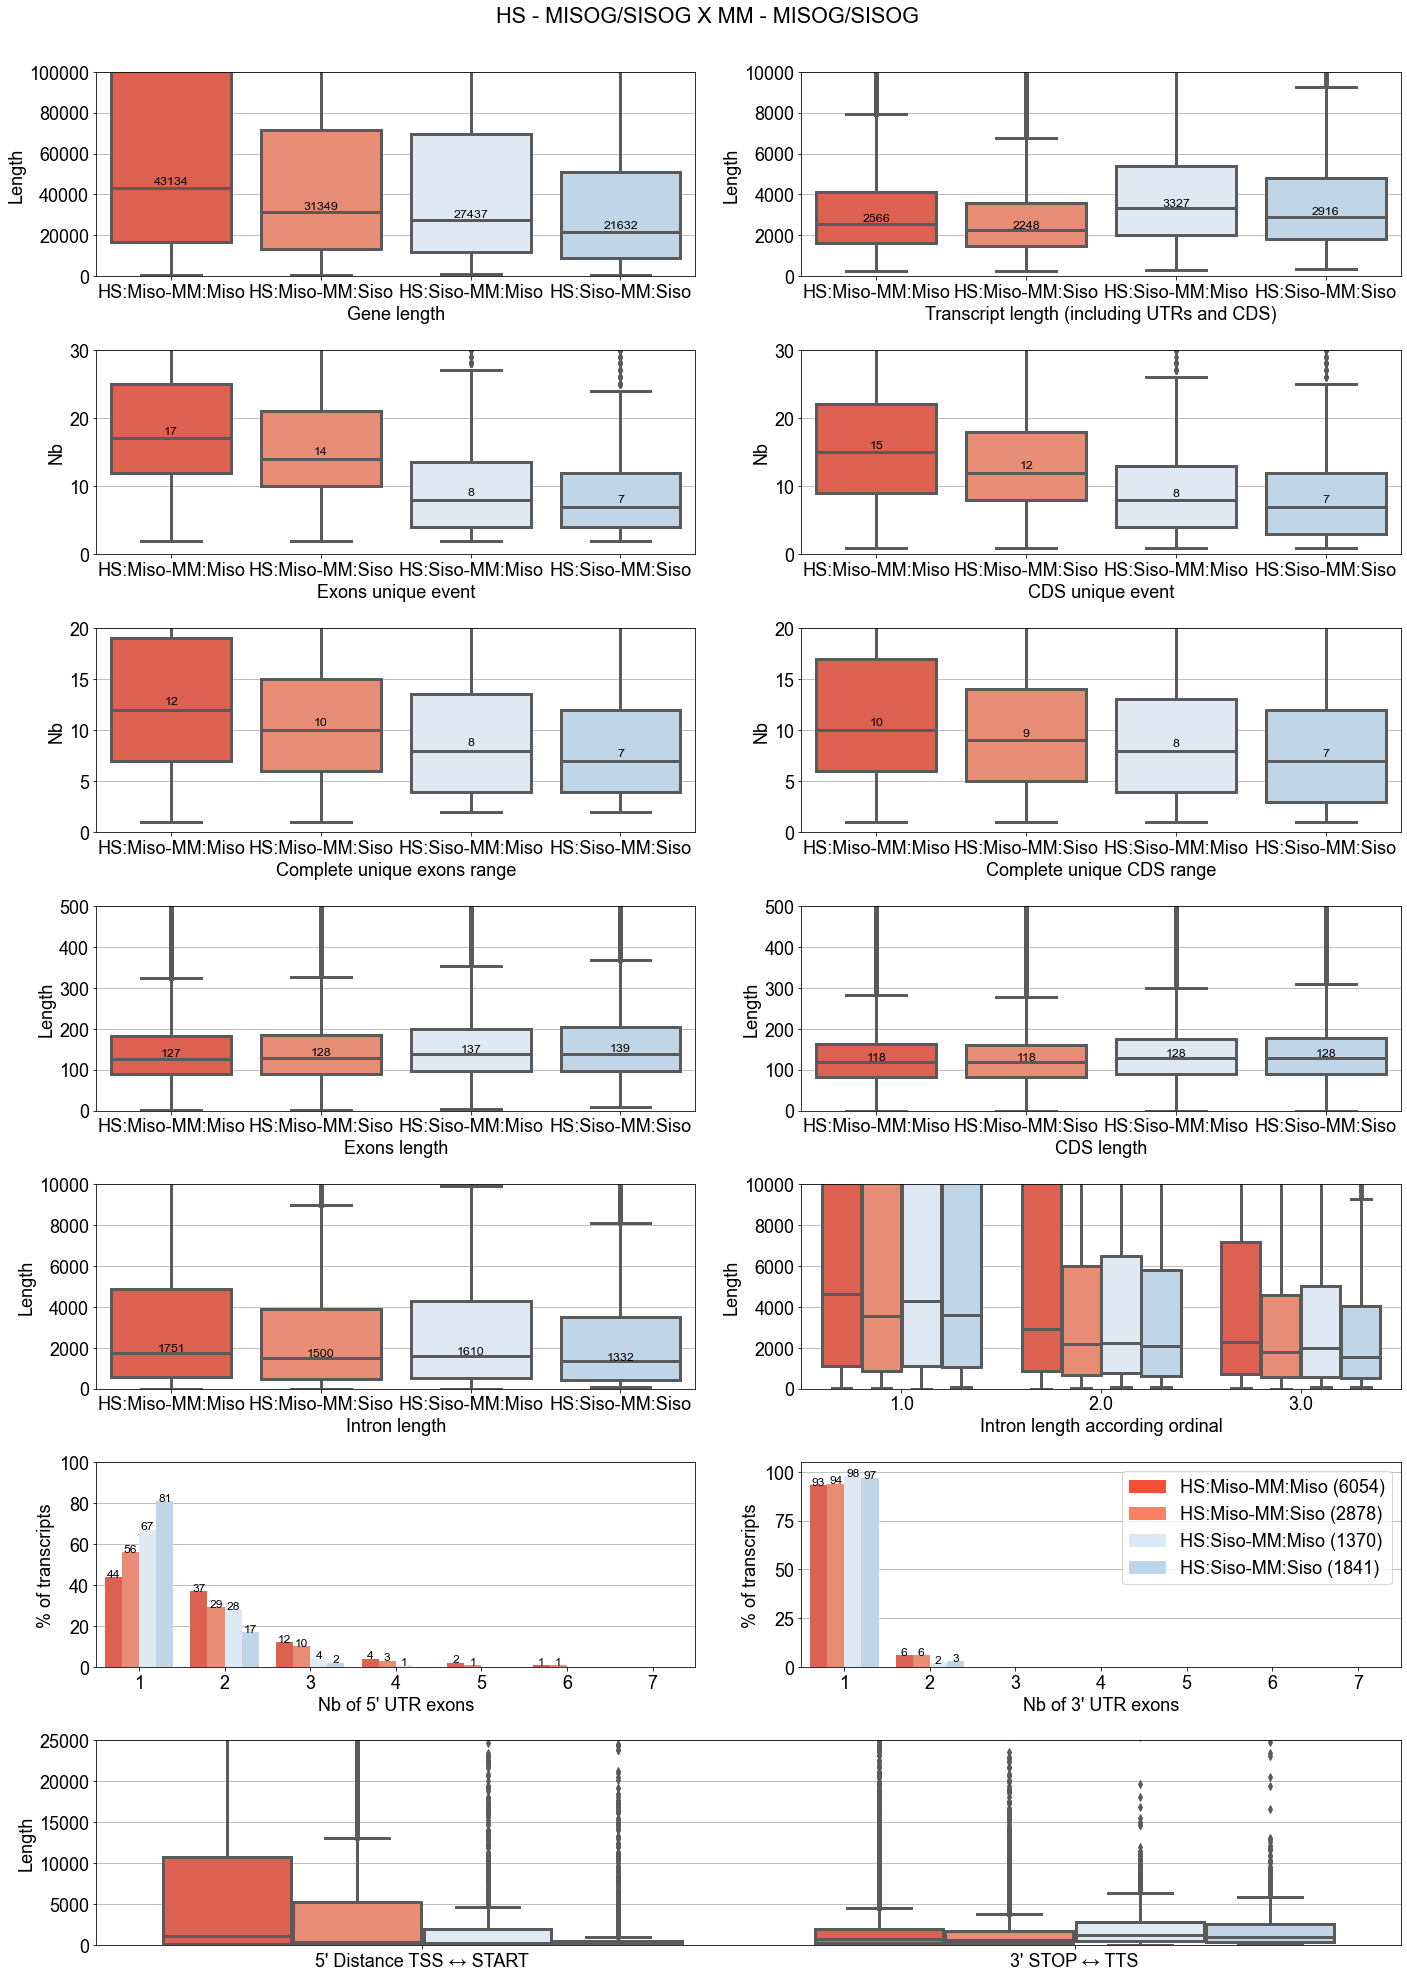

In [549]:
hs_genes_new = pd.merge( hs_genes.drop(['Miso_siso'], axis=1), new_count.drop(['Miso_siso'], axis=1), on='GeneID').rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)
hs_mrna_new = pd.merge( hs_mrna.drop(['Miso_siso'], axis=1), new_count.drop(['Miso_siso'], axis=1), on='GeneID').rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)

hs_five_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_five_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)
hs_three_UTR_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_three_UTR, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)
hs_exons_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_exons, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)
hs_cds_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_cds, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)
hs_introns_new = pd.merge(hs_genes[['GeneID', 'transcript_count']], pd.merge(hs_introns, new_count.drop(['Miso_siso'], axis=1), on='GeneID')).drop(['Miso_siso'], axis=1).rename({'Miso_siso_full' : 'Miso_siso'}, axis=1)

hs_five_UTR_new = hs_five_UTR_new.sort_values(by=['Miso_siso'], ascending=True)
hs_three_UTR_new = hs_three_UTR_new.sort_values(by=['Miso_siso'], ascending=True)
hs_exons_new = hs_exons_new.sort_values(by=['Miso_siso'], ascending=True)
hs_cds_new = hs_cds_new.sort_values(by=['Miso_siso'], ascending=True)
hs_introns_new = hs_introns_new.sort_values(by=['Miso_siso'], ascending=True)


# hs_cds_new

# hs_five_UTR_new = hs_five_UTR
# hs_three_UTR_new = hs_three_UTR
# hs_exons_new = hs_exons
# hs_cds_new = hs_cds
# hs_introns_new = hs_introns
# hs_genes_new = hs_genes
# hs_mrna_new = hs_mrna


# hs_cds_new = hs_cds_new.groupby('GeneID').progress_apply(overlap_apply)
# hs_exons_new = hs_exons_new.groupby('GeneID').progress_apply(overlap_apply)

palette= sns.color_palette('Reds')[3:4] + sns.color_palette('Reds')[2:3] + sns.color_palette('Blues')[0:1] + sns.color_palette('Blues')[1:2]

f = custom_figure(hs_five_UTR_new, hs_three_UTR_new, hs_exons_new, hs_cds_new, hs_introns_new, hs_genes_new, hs_mrna_new, palette=palette, title='HS - MISOG/SISOG X MM - MISOG/SISOG', alpha=1)
f.savefig('/gstock/GeneIso/V2/Figures/HSxMM_misog_sisog_box.png', dpi=300)

[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
  Miso_siso  Ordinal_nb  Length
0      Miso           1   180.0
1      Miso           2   128.0
2      Miso           3   124.0
3      Miso           4   123.0
4      Miso           5   123.0
  Miso_siso  Ordinal_nb  Length
5      Siso           1   216.5
6      Siso           2   143.0
7      Siso           3   133.0
8      Siso           4   130.0
9      Siso           5   128.0
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.726e-41 U_stat=5.219e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.344e-53 U_stat=5.185e+07
3_Miso v.s. 3_S

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


  Miso_siso  Ordinal_nb_inverted  Length
0      Miso                   -5    98.5
1      Miso                   -4   102.0
2      Miso                   -3   103.0
3      Miso                   -2    32.0
4      Miso                   -1   722.0
  Miso_siso  Ordinal_nb_inverted  Length
5      Siso                   -5    87.0
6      Siso                   -4    92.0
7      Siso                   -3   107.0
8      Siso                   -2    79.0
9      Siso                   -1   763.0
-4_Miso v.s. -4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.802e+03
-5_Miso v.s. -5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.544e+03
-3_Miso v.s. -3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.441e+04
-2_Miso v.s. -2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.570e-17 U_stat=4.117e+05
-1_Miso v.s. -1_Siso: Mann-W

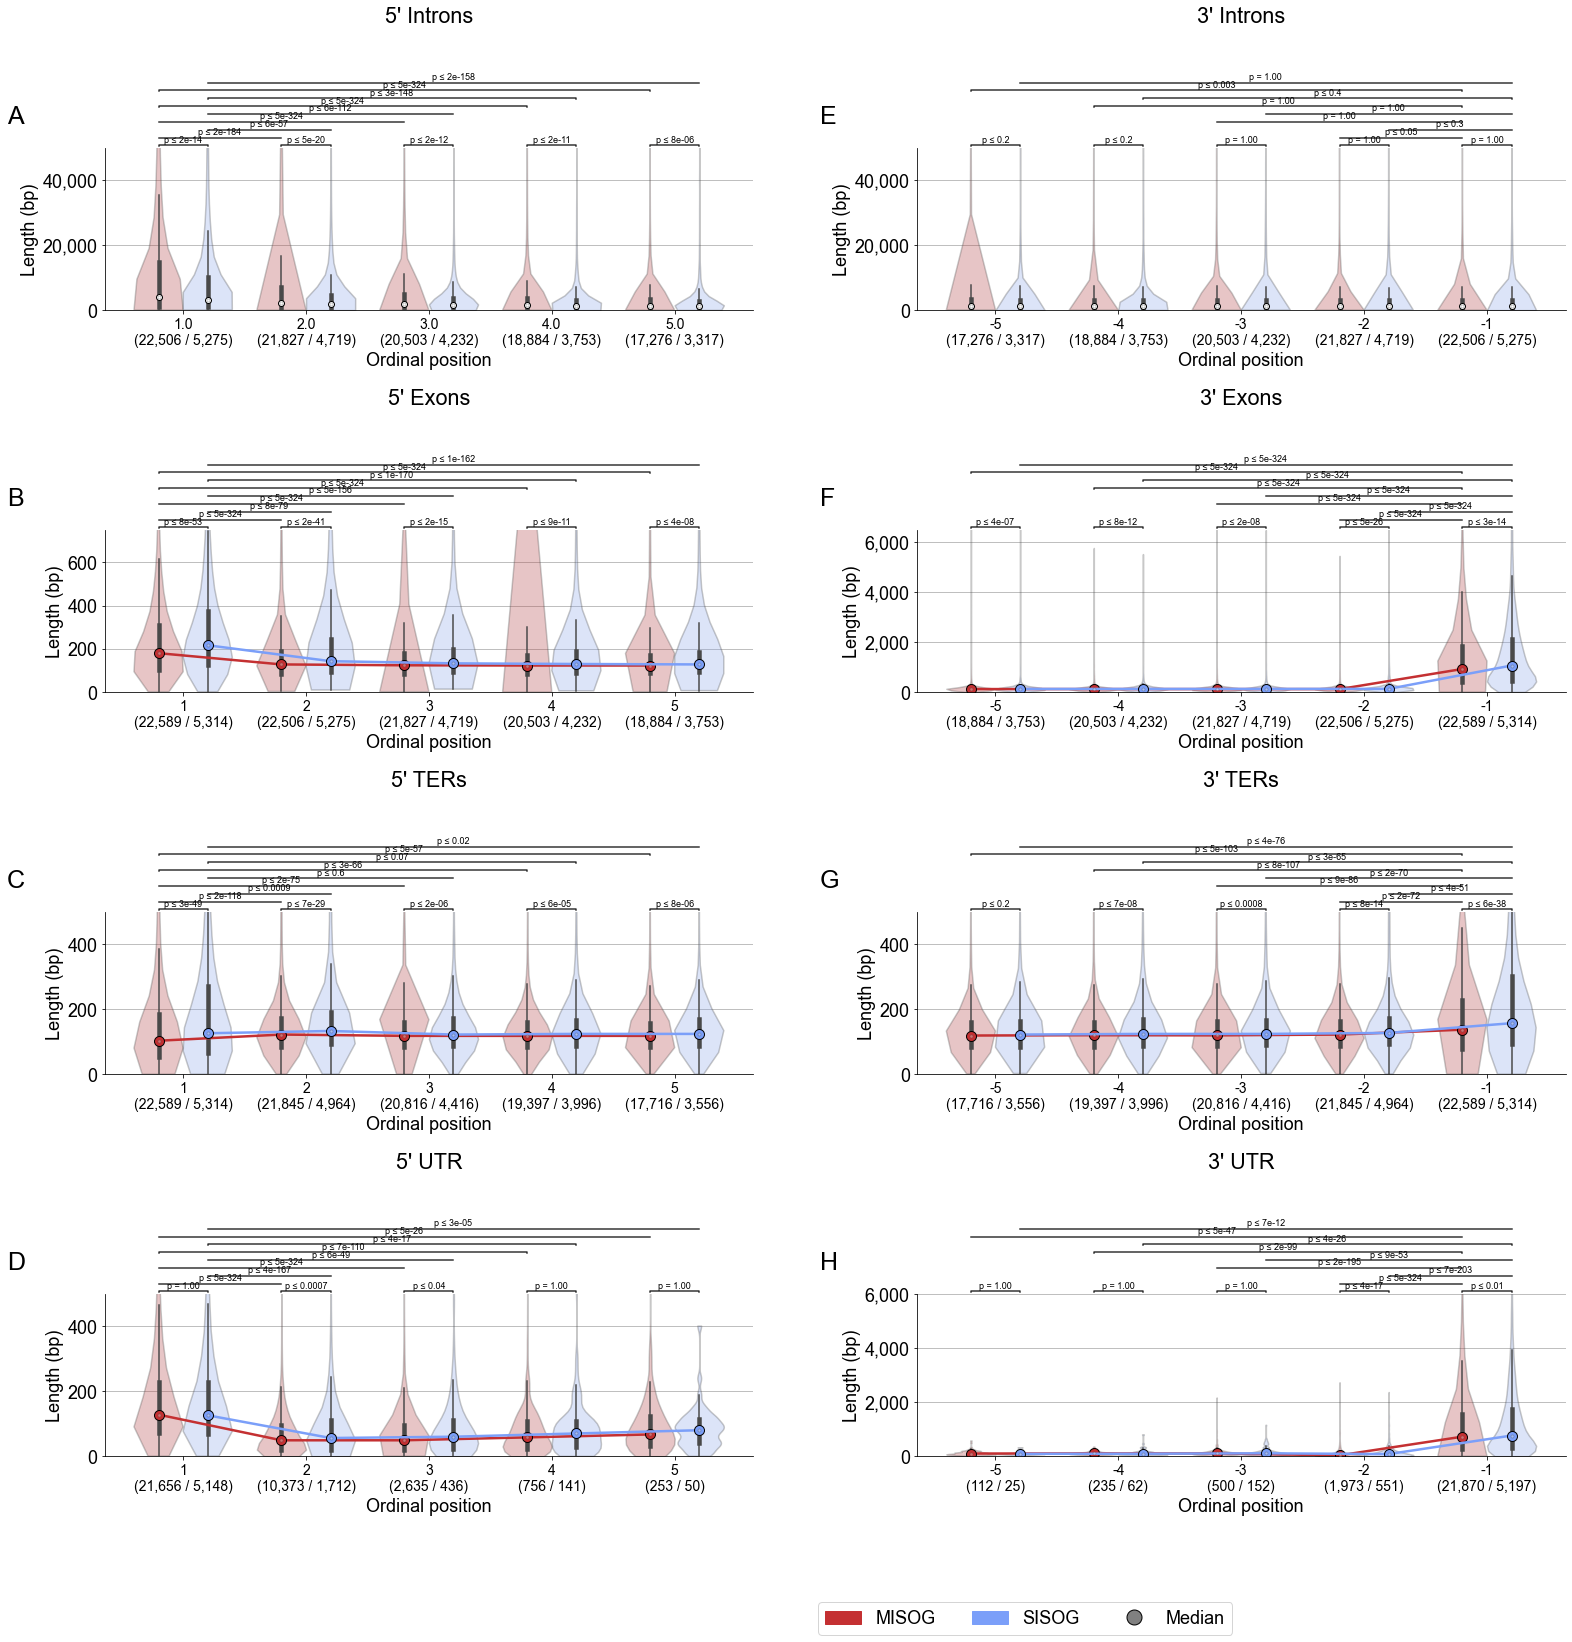

In [97]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]

box_pairs = box_pairs + [((1,'Miso'),(e,'Miso')) for e in range(2,6)] + [((1,'Siso'),(e,'Siso')) for e in range(2,6)]

print(box_pairs)

k_limit = 5
zscore_cutoff = 2
padding_title = 125


custom_boxplot(data=exons.loc[(exons['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=five_UTR.loc[(five_UTR['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]
box_pairs = box_pairs + [((-1,'Miso'),(e,'Miso')) for e in range(-5,-1)] + [((-1,'Siso'),(e,'Siso')) for e in range(-5,-1)]

custom_boxplot(data=exons.loc[(exons['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[1][1], ylim=(0,6.5e3), palette=palette, title="3' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso', xlabel='Ordinal position',ax=ax[2][1], ylim=(0,500), palette=palette, title="3' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[0][1], ylim=(0,50e3), palette=palette, title="3' Introns", box_pairs=box_pairs, padding_title=padding_title, )
custom_boxplot(data=three_UTR.loc[(three_UTR['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',  xlabel='Ordinal position',ax=ax[3][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.35,)


i = 0
for n, a in enumerate(ax):
    sub_a = a[0]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1
for n, a in enumerate(ax):
    sub_a = a[1]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['FigS1']
# f.savefig(figure_path, dpi=600)

# Enrichment into changing category genes

In [551]:
# Compute Nb of Unique exons

def overlaps(ranges):
    ranges = sorted(ranges)  # If our inputs are garunteed sorted, we can skip this
    it = iter(ranges)
    try:
        curr_start, curr_stop = next(it)
        # overlaps = False  # If we want to exclude output ranges not produced by overlapping input ranges
    except StopIteration:
        return
    for start, stop in it:
        if curr_start <= start <= curr_stop:  # Assumes intervals are closed
            curr_stop = max(curr_stop, stop)
            # overlaps = True
        else:
            # if overlaps:
            yield curr_start, curr_stop
            curr_start, curr_stop = start, stop
            # overlaps = False
    # if overlaps:
    yield curr_start, curr_stop

def overlap_apply(df):
    r = df.drop_duplicates(subset=['ranges'])
    r = r.ranges.tolist()
    r = [(int(e.split('-')[0]), int(e.split('-')[1])) for e in r]
    df['CDS_unique_nb'] = len(list(overlaps(r)))
    return df


# Unique CDS

In [214]:
cds[['Miso_siso', 'GeneID', 'CDS_unique_nb']].drop_duplicates().groupby('Miso_siso').describe()

CDS_unique_nb                                                   
                  count       mean        std  min  25%   50%   75%    max
Miso_siso                                                                 
Miso             8933.0  12.046009   9.891078  1.0  5.0  10.0  16.0  145.0
Siso             3221.0   9.891028  10.144985  1.0  4.0   7.0  12.0  107.0

In [16]:
hs_exons[['GeneID', 'CDS_unique_nb']].drop_duplicates()

,GeneID,CDS_unique_nb
0,ENSG00000000003,9
22,ENSG00000000419,11
59,ENSG00000000457,14
99,ENSG00000000460,26
183,ENSG00000000938,14
...,...,...
536213,ENSG00000286143,7
536220,ENSG00000286185,97
536317,ENSG00000286190,2
536319,ENSG00000287542,26


In [96]:
[0.2] + [0.1] * (len(list(ratio_stats.columns))-1)

[0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

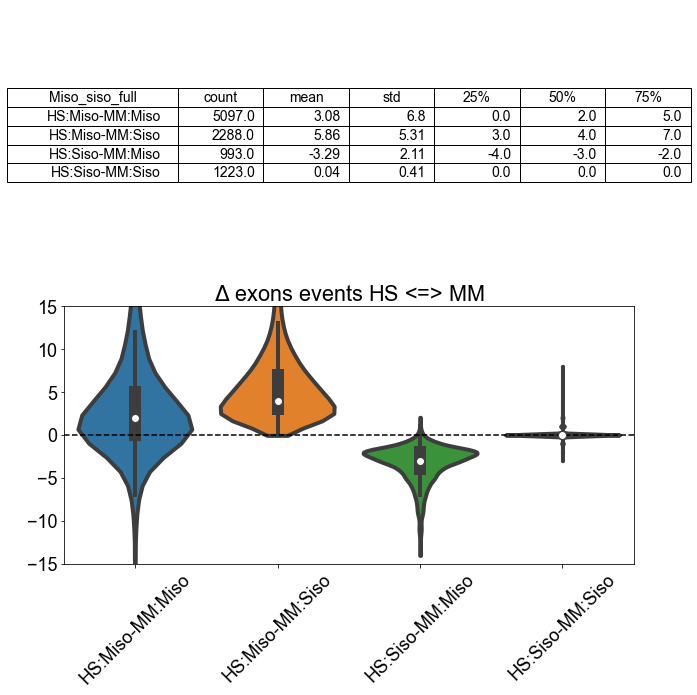

In [178]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() - exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-15,15)

plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")

ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ exons events HS <=> MM')
plt.tight_layout()
f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon_events.png', dpi=300)

In [4]:
pd

NameError: name 'pd' is not defined

In [2]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_five_UTR.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() - five_UTR.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-15,15)

plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")

ax[1].set_xlabel("")
ax[1].set_title(r"$\Delta$ 5' UTR exons events HS <=> MM")
plt.tight_layout()
f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon5UTR_events.png', dpi=300)

NameError: name 'hs_cds' is not defined

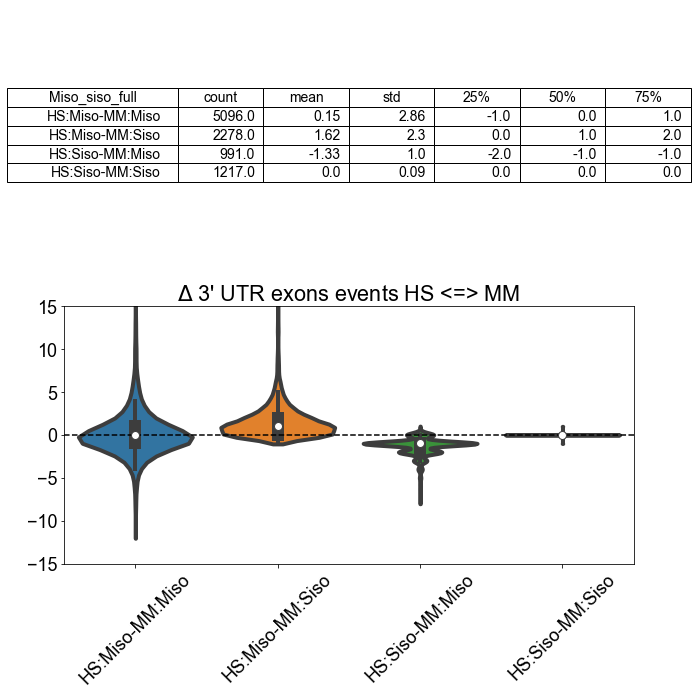

In [181]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_three_UTR.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() - three_UTR.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-15,15)

plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")

ax[1].set_xlabel("")
ax[1].set_title(r"$\Delta$ 3' UTR exons events HS <=> MM")
plt.tight_layout()
f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon5UTR_events.png', dpi=300)

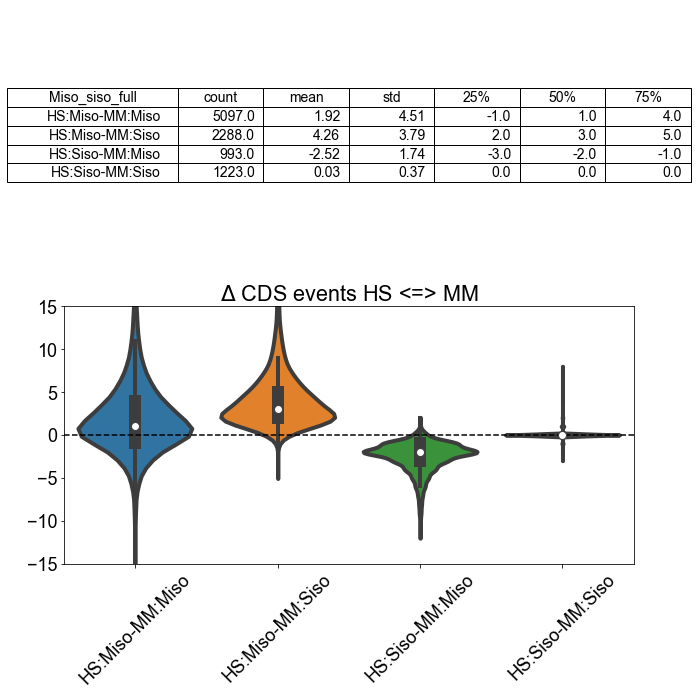

In [148]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_cds.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() - cds.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-15,15)

plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")

ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ CDS events HS <=> MM')
plt.tight_layout()
f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_cds_events.png', dpi=300)

In [115]:
exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])

Miso_siso  GeneID         
Miso       ENSG00000000003     8
           ENSG00000000419    10
           ENSG00000000457    15
           ENSG00000000460    25
           ENSG00000000938    14
                              ..
Siso       ENSG00000283528     8
           ENSG00000283632    12
           ENSG00000283706     5
           ENSG00000283900    14
           ENSG00000284753     2
Name: CDS_unique_nb, Length: 12154, dtype: int64

,GeneID,ensembl_gene_id,Miso_siso,Miso_siso_mm,Miso_siso_full
0,ENSG00000000003,ENSMUSG00000067377,Miso,Siso,HS:Miso-MM:Siso
1,ENSG00000000005,ENSMUSG00000031250,Siso,Siso,HS:Siso-MM:Siso
2,ENSG00000000419,ENSMUSG00000078919,Miso,Miso,HS:Miso-MM:Miso
4,ENSG00000000457,ENSMUSG00000026584,Miso,Miso,HS:Miso-MM:Miso
7,ENSG00000000460,ENSMUSG00000041406,Miso,Miso,HS:Miso-MM:Miso
...,...,...,...,...,...
27895,ENSG00000284194,ENSMUSG00000091780,Miso,Miso,HS:Miso-MM:Miso
27897,ENSG00000284308,ENSMUSG00000030030,Miso,Miso,HS:Miso-MM:Miso
27899,ENSG00000284753,ENSMUSG00000115219,Siso,Miso,HS:Siso-MM:Miso
27901,ENSG00000284770,ENSMUSG00000039233,Miso,Siso,HS:Miso-MM:Siso


In [134]:
test = pd.merge(
    pd.merge(
        hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]).reset_index().rename({'Miso_siso' : 'HS_Miso_siso', 'CDS_unique_nb' : 'HS_Unique_nb'}, axis=1),
        exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]).reset_index().rename({'Miso_siso' : 'HS_Miso_siso2', 'CDS_unique_nb' : 'MM_Unique_nb'}, axis=1),
        on='GeneID'
),
    new_count,
    on='GeneID'
)
test['Delta'] = test['HS_Unique_nb'] - test['MM_Unique_nb']
test.groupby(['Miso_siso_full'])['Delta'].describe()

,count,mean,std,min,25%,50%,75%,max
Miso_siso_full,,,,,,,,
HS:Miso-MM:Miso,6054.0,0.533532,1.863715,-23.0,0.0,0.0,1.0,20.0
HS:Miso-MM:Siso,2879.0,0.982980,1.553333,-9.0,0.0,1.0,1.0,19.0
HS:Siso-MM:Miso,1375.0,-0.552000,1.039970,-6.0,-1.0,0.0,0.0,5.0
HS:Siso-MM:Siso,1846.0,0.040087,0.413219,-3.0,0.0,0.0,0.0,8.0


In [126]:
exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])

Miso_siso  GeneID         
Miso       ENSG00000000003     8
           ENSG00000000419    10
           ENSG00000000457    15
           ENSG00000000460    25
           ENSG00000000938    14
                              ..
Siso       ENSG00000283528     8
           ENSG00000283632    12
           ENSG00000283706     5
           ENSG00000283900    14
           ENSG00000284753     2
Name: CDS_unique_nb, Length: 12154, dtype: int64

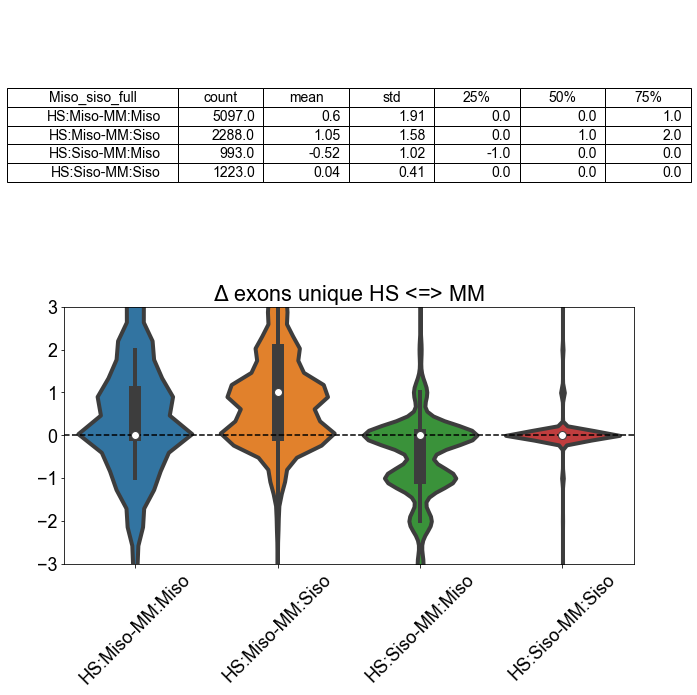

In [177]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ exons unique HS <=> MM')
ax[1].set_ylim(-3,3)
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon_unique.png', dpi=300)

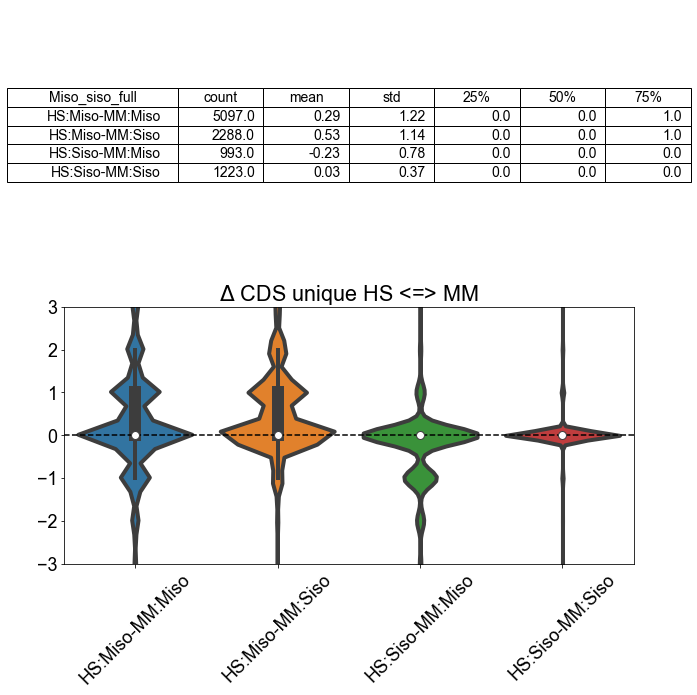

In [151]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_cds.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - cds.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ CDS unique HS <=> MM')
ax[1].set_ylim(-3,3)
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_cds_unique.png', dpi=300)

In [169]:
hs_five_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])

Miso_siso  GeneID         
Miso       ENSG00000000003     3
           ENSG00000000419     5
           ENSG00000000457     2
           ENSG00000000460    15
           ENSG00000000938     4
                              ..
Siso       ENSG00000286019     1
           ENSG00000286185     5
           ENSG00000286190     1
           ENSG00000287542     4
           ENSG00000288920     4
Name: CDS_unique_nb, Length: 13461, dtype: int64

In [170]:
five_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])

Miso_siso  GeneID         
Miso       ENSG00000000003    1
           ENSG00000000419    2
           ENSG00000000457    3
           ENSG00000000460    1
           ENSG00000000938    4
                             ..
Siso       ENSG00000283528    2
           ENSG00000283632    3
           ENSG00000283706    1
           ENSG00000283900    3
           ENSG00000284753    1
Name: CDS_unique_nb, Length: 12099, dtype: int64

In [171]:
new_count

,GeneID,ensembl_gene_id,Miso_siso,Miso_siso_mm,Miso_siso_full
0,ENSG00000000003,ENSMUSG00000067377,Miso,Siso,HS:Miso-MM:Siso
1,ENSG00000000005,ENSMUSG00000031250,Siso,Siso,HS:Siso-MM:Siso
2,ENSG00000000419,ENSMUSG00000078919,Miso,Miso,HS:Miso-MM:Miso
4,ENSG00000000457,ENSMUSG00000026584,Miso,Miso,HS:Miso-MM:Miso
7,ENSG00000000460,ENSMUSG00000041406,Miso,Miso,HS:Miso-MM:Miso
...,...,...,...,...,...
27895,ENSG00000284194,ENSMUSG00000091780,Miso,Miso,HS:Miso-MM:Miso
27897,ENSG00000284308,ENSMUSG00000030030,Miso,Miso,HS:Miso-MM:Miso
27899,ENSG00000284753,ENSMUSG00000115219,Siso,Miso,HS:Siso-MM:Miso
27901,ENSG00000284770,ENSMUSG00000039233,Miso,Siso,HS:Miso-MM:Siso


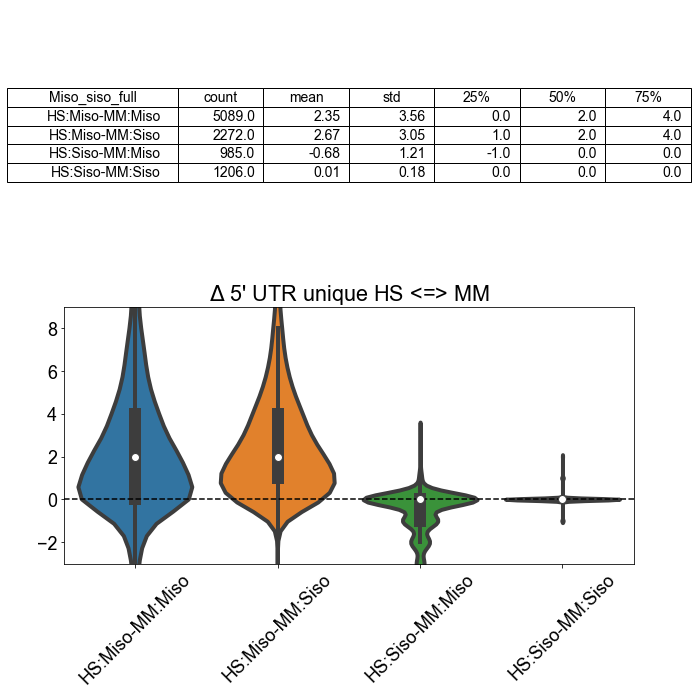

In [172]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_five_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - five_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, ax=ax[1], scale="width")
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r"$\Delta$ 5' UTR unique HS <=> MM")
ax[1].set_ylim(-3,9)
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_fiveUTR_unique.png', dpi=300)

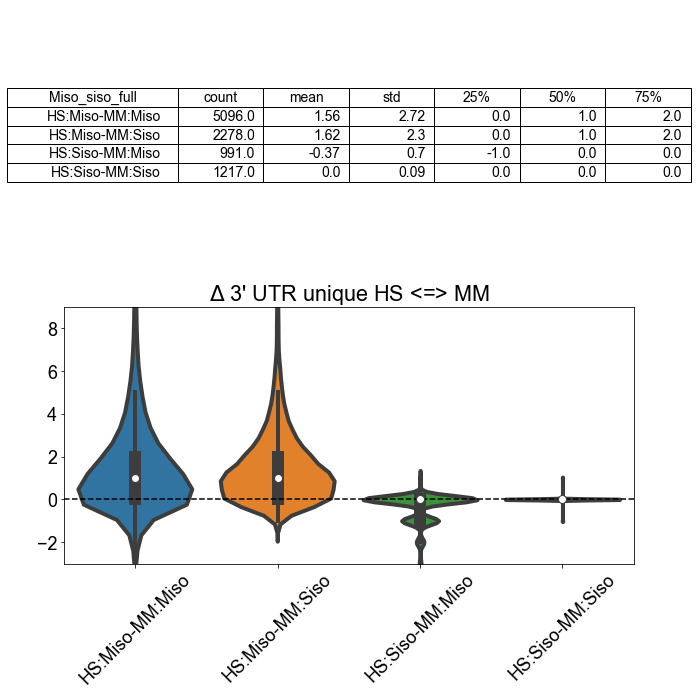

In [182]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_three_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - three_UTR.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

f,ax=plt.subplots(nrows=2, figsize=(10,10))

ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()
ratio_stats

table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help

sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, ax=ax[1], scale="width")
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r"$\Delta$ 3' UTR unique HS <=> MM")
ax[1].set_ylim(-3,9)
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_threeUTR_unique.png', dpi=300)

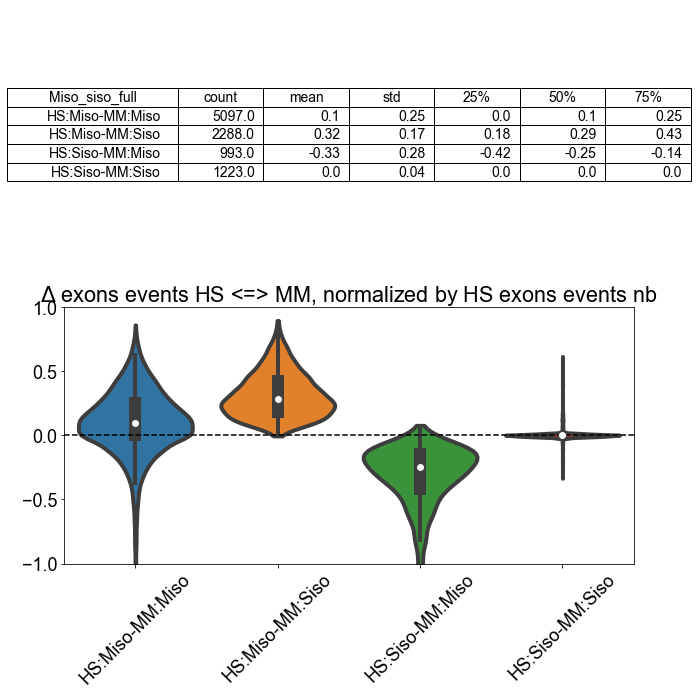

In [174]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = (hs_exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() - exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()) / hs_exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]


ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

f,ax=plt.subplots(nrows=2, figsize=(10,10))


table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help


sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-1,1)
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ exons events HS <=> MM, normalized by HS exons events nb')
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon_events_normalized_by_HS.png', dpi=300)

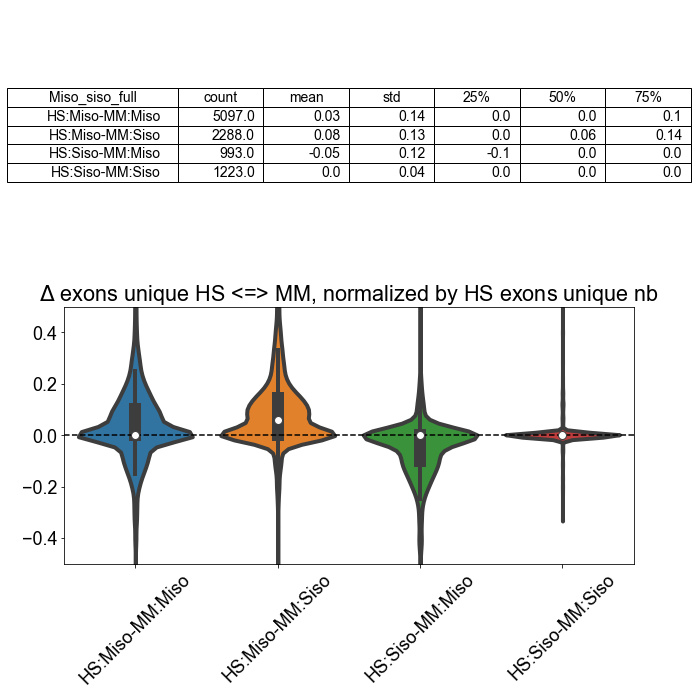

In [175]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = (hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])) / hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]


ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

f,ax=plt.subplots(nrows=2, figsize=(10,10))


table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help



sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-0.5,0.5)
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ exons unique HS <=> MM, normalized by HS exons unique nb')
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon_unique_normalized_by_HS.png', dpi=300)

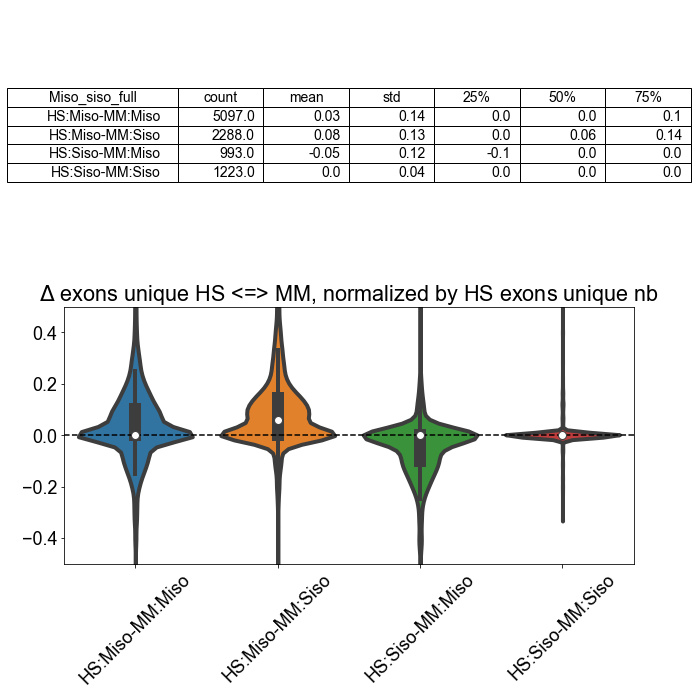

In [176]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = (hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])) / hs_exons.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]


ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

f,ax=plt.subplots(nrows=2, figsize=(10,10))


table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help



sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-0.5,0.5)
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ exons unique HS <=> MM, normalized by HS exons unique nb')
plt.tight_layout()

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_exon_unique_normalized_by_HS.png', dpi=300)

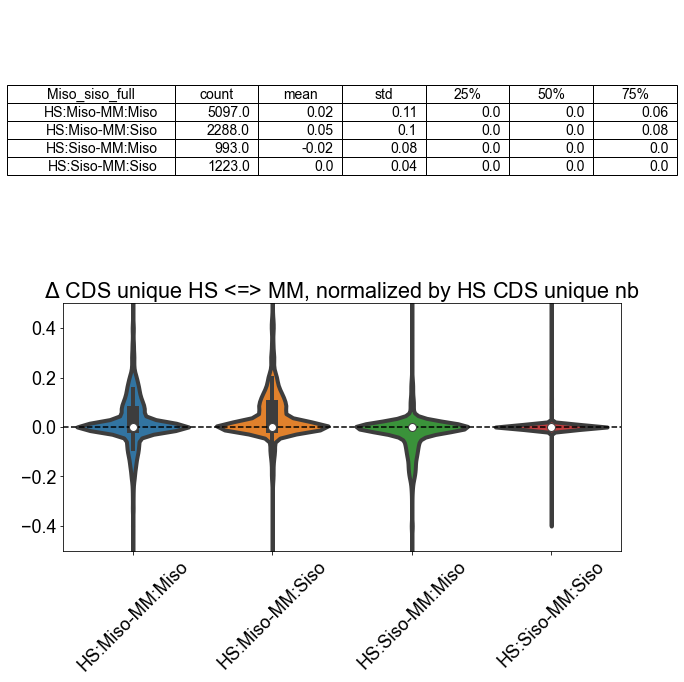

In [154]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_cds[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = (hs_cds.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0]) - cds.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])) / hs_cds.groupby(['Miso_siso', 'GeneID'])['CDS_unique_nb'].unique().apply(lambda r: r[0])
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]


ratio_stats = ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

f,ax=plt.subplots(nrows=2, figsize=(10,10))


table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2] + [0.1] * (len(list(ratio_stats.columns))-1))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help



sns.violinplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(-0.5,0.5)
plt.axhline(0, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title(r'$\Delta$ CDS unique HS <=> MM, normalized by HS CDS unique nb')

f.savefig('/gstock/GeneIso/V2/Figures/Box/delta_cds_unique_normalized_by_HS.png', dpi=300)

,count,mean,std,min,25%,50%,75%,max
Miso_siso_full,,,,,,,,
HS:Miso-MM:Miso,5521.0,1.238900,0.511409,0.347826,1.000000,1.117647,1.363636,9.750000
HS:Miso-MM:Siso,2465.0,1.720360,0.985775,1.000000,1.235294,1.428571,1.833333,25.333333
HS:Siso-MM:Miso,1029.0,0.772346,0.134169,0.300000,0.700000,0.791667,0.875000,1.666667
HS:Siso-MM:Siso,1247.0,1.009412,0.108814,0.750000,1.000000,1.000000,1.000000,4.000000


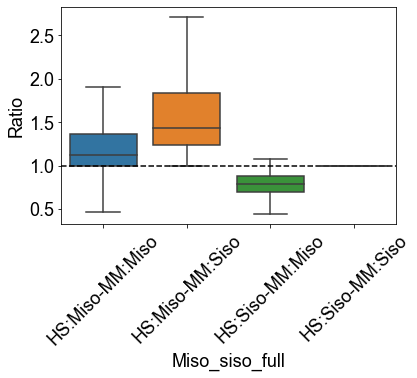

In [47]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])

cds_count = hs_exons[['GeneID', 'CDS_unique_nb']].drop_duplicates()

ratio = hs_exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique() / exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(new_count.drop(['Miso_siso'], axis=1), ratio, on='GeneID')
# ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
ratio = ratio.loc[ratio['GeneID'].isin(cds_count.loc[cds_count['CDS_unique_nb'] >= 5].GeneID.values.tolist())]

ratio = pd.merge(hs_exons.groupby(['GeneID'])['ranges'].nunique().rename('HS_count').reset_index(), ratio, on='GeneID')
ratio = pd.merge(exons.groupby(['GeneID'])['ranges'].nunique().rename('MM_count').reset_index(), ratio, on='GeneID')



f,ax=plt.subplots()
sns.boxplot(data=ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True), x='Miso_siso_full', y='Ratio', showfliers=False, ax=ax)
plt.axhline(1, ls='--', color='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=True).groupby('Miso_siso_full')['Ratio'].describe()
# ratio

In [105]:
ratio_stats = data.sort_values(['Miso_siso_full'], ascending=True).groupby(['Miso_siso_full', 'variable'])['value'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

ratio_stats

,Miso_siso_full,variable,count,mean,std,25%,50%,75%
0,HS:Miso-MM:Miso,HS_count,6054.0,20.26,12.72,12.0,17.0,25.0
1,HS:Miso-MM:Miso,MM_count,6054.0,17.42,11.02,10.0,15.0,22.0
2,HS:Miso-MM:Siso,HS_count,2879.0,16.72,10.48,10.0,14.0,21.0
3,HS:Miso-MM:Siso,MM_count,2879.0,11.06,8.83,5.0,9.0,14.0
4,HS:Siso-MM:Miso,HS_count,1375.0,10.86,10.66,4.0,8.0,13.5
5,HS:Siso-MM:Miso,MM_count,1375.0,14.14,10.96,8.0,12.0,17.0
6,HS:Siso-MM:Siso,HS_count,1846.0,9.62,9.61,4.0,7.0,12.0
7,HS:Siso-MM:Siso,MM_count,1846.0,9.58,9.61,4.0,7.0,12.0


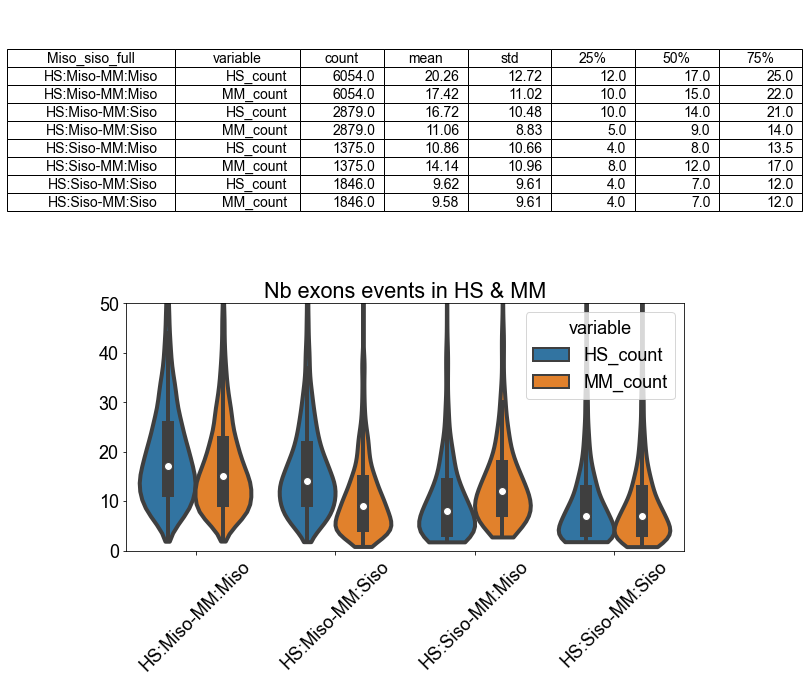

In [146]:
data = pd.merge(
    pd.merge(
        hs_exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique().rename('HS_count').reset_index().drop(['Miso_siso'], axis=1),
        exons.groupby(['Miso_siso', 'GeneID'])['ranges'].nunique().rename('MM_count').reset_index().drop(['Miso_siso'], axis=1),
        on='GeneID'
    ),
    new_count.drop(['Miso_siso'], axis=1),
    on='GeneID'
)
data = data.melt(id_vars=['GeneID', 'Miso_siso_full'], value_vars=['HS_count', 'MM_count'])
# data = data.loc[data['value'] >= 5]


ratio_stats = data.sort_values(['Miso_siso_full'], ascending=True).groupby(['Miso_siso_full', 'variable'])['value'].describe().drop(['min', 'max'], axis=1).round(2).reset_index()

ratio_stats

f,ax=plt.subplots(nrows=2, figsize=(10,10))


table = ax[0].table(cellText=ratio_stats.values, colLabels=ratio_stats.columns, loc='center', colWidths=[0.2, 0.15] + [0.1] * (len(list(ratio_stats.columns))-2))
ax[0].axis('tight')
ax[0].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)  # may help



sns.violinplot(data=data.sort_values(['Miso_siso_full'], ascending=True), x='Miso_siso_full', y='value', hue='variable', showfliers=False, linewidth=4, cut=0.1, ax=ax[1], scale="width")
ax[1].set_ylim(0,50)
# plt.axhline(1, ls='--', color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title('Nb exons events in HS & MM')

f.savefig('/gstock/GeneIso/V2/Figures/Box/nb_exon_events.png', dpi=300)


# Exon differential

In [56]:
# filter_ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
filter_ratio_miso_siso = ratio.loc[(ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso'])) & (ratio['Ratio'] == 1)]
filter_ratio_miso_siso

,GeneID,MM_count,HS_count,ensembl_gene_id,Miso_siso_mm,Miso_siso_full,Miso_siso,Ratio
1871,ENSG00000101639,46,46,ENSMUSG00000024542,Siso,HS:Miso-MM:Siso,Miso,1.0
1995,ENSG00000103021,9,9,ENSMUSG00000036598,Siso,HS:Miso-MM:Siso,Miso,1.0
2304,ENSG00000105755,8,8,ENSMUSG00000064254,Siso,HS:Miso-MM:Siso,Miso,1.0
5521,ENSG00000142583,14,14,ENSMUSG00000028976,Siso,HS:Miso-MM:Siso,Miso,1.0
6867,ENSG00000160753,19,19,ENSMUSG00000105204,Siso,HS:Miso-MM:Siso,Miso,1.0
7080,ENSG00000163006,16,16,ENSMUSG00000038010,Siso,HS:Miso-MM:Siso,Miso,1.0
7723,ENSG00000167272,6,6,ENSMUSG00000060152,Siso,HS:Miso-MM:Siso,Miso,1.0
8162,ENSG00000171435,21,21,ENSMUSG00000061578,Siso,HS:Miso-MM:Siso,Miso,1.0
9063,ENSG00000185019,6,6,ENSMUSG00000027300,Siso,HS:Miso-MM:Siso,Miso,1.0
9452,ENSG00000196547,24,24,ENSMUSG00000038886,Siso,HS:Miso-MM:Siso,Miso,1.0


In [55]:
# filter_ratio = ratio.loc[ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso', 'HS:Siso-MM:Miso'])]
filter_ratio_miso_siso = ratio.loc[(ratio['Miso_siso_full'].isin(['HS:Miso-MM:Siso'])) & (ratio['Ratio'] > 1)]
filter_ratio_miso_siso

,GeneID,MM_count,HS_count,ensembl_gene_id,Miso_siso_mm,Miso_siso_full,Miso_siso,Ratio
0,ENSG00000000003,8,11,ENSMUSG00000067377,Siso,HS:Miso-MM:Siso,Miso,1.375000
7,ENSG00000001084,16,23,ENSMUSG00000032350,Siso,HS:Miso-MM:Siso,Miso,1.437500
9,ENSG00000001460,9,12,ENSMUSG00000028801,Siso,HS:Miso-MM:Siso,Miso,1.333333
14,ENSG00000001630,10,14,ENSMUSG00000001467,Siso,HS:Miso-MM:Siso,Miso,1.400000
17,ENSG00000002549,13,17,ENSMUSG00000039682,Siso,HS:Miso-MM:Siso,Miso,1.307692
...,...,...,...,...,...,...,...,...
10240,ENSG00000276234,16,20,ENSMUSG00000018651,Siso,HS:Miso-MM:Siso,Miso,1.250000
10251,ENSG00000278535,7,9,ENSMUSG00000034449,Siso,HS:Miso-MM:Siso,Miso,1.285714
10253,ENSG00000278619,5,6,ENSMUSG00000018405,Siso,HS:Miso-MM:Siso,Miso,1.200000
10254,ENSG00000278845,8,10,ENSMUSG00000018882,Siso,HS:Miso-MM:Siso,Miso,1.250000


In [296]:
# hs_exons = hs_exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
hs_exons = hs_exons.loc[hs_exons['Length'] > 0]

# exons = exons.drop_duplicates(subset=['Miso_siso', 'GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'Length'])
exons = exons.loc[exons['Length'] > 0]

ratio = hs_exons.groupby(['GeneID'])['Exon region start (bp)'].nunique() / exons.groupby(['GeneID'])['Exon region start (bp)'].nunique()
ratio = ratio.dropna().rename('Ratio')
ratio = ratio.reset_index()
ratio = pd.merge(ratio, new_count, on='GeneID')
ratio = pd.merge(ratio, genes[['GeneID', 'Gene name', 'external_gene_name']].drop_duplicates(), on='GeneID')
ratio = ratio.loc[ratio['GeneID'].isin(tmp.loc[tmp['CDS_unique_nb'] >= 5].GeneID.values.tolist())]
ratio.sort_values(['Miso_siso_full', 'Ratio'], ascending=False).groupby('Miso_siso_full').head(10)


,GeneID,Ratio,ensembl_gene_id,Miso_siso,Miso_siso_mm,Miso_siso_full,Gene name,external_gene_name
6919,ENSG00000151657,2.600000,ENSMUSG00000037262,Siso,Siso,HS:Siso-MM:Siso,KIN,Kin
11937,ENSG00000250021,1.666667,ENSMUSG00000039043,Siso,Siso,HS:Siso-MM:Siso,ARPIN-AP3S2,Arpin
2398,ENSG00000105523,1.400000,ENSMUSG00000054161,Siso,Siso,HS:Siso-MM:Siso,FAM83E,Fam83e
5881,ENSG00000140259,1.285714,ENSMUSG00000068479,Siso,Siso,HS:Siso-MM:Siso,MFAP1,Mfap1a
4070,ENSG00000123154,1.222222,ENSMUSG00000005150,Siso,Siso,HS:Siso-MM:Siso,WDR83,Wdr83
2250,ENSG00000104369,1.200000,ENSMUSG00000042686,Siso,Siso,HS:Siso-MM:Siso,JPH1,Jph1
3552,ENSG00000116704,1.200000,ENSMUSG00000028521,Siso,Siso,HS:Siso-MM:Siso,SLC35D1,Slc35d1
9055,ENSG00000169857,1.200000,ENSMUSG00000003604,Siso,Siso,HS:Siso-MM:Siso,AVEN,Aven
10964,ENSG00000196126,1.200000,ENSMUSG00000067341,Siso,Siso,HS:Siso-MM:Siso,HLA-DRB1,H2-Eb2
12146,ENSG00000283706,1.200000,ENSMUSG00000048752,Siso,Siso,HS:Siso-MM:Siso,PRSS50,Prss50


In [297]:
ratio.loc[ratio['Miso_siso_full'] == 'HS:Miso-MM:Siso']['GeneID'].values.tolist()

,GeneID,Ratio,ensembl_gene_id,Miso_siso,Miso_siso_mm,Miso_siso_full,Gene name,external_gene_name
0,ENSG00000000003,1.375000,ENSMUSG00000067377,Miso,Siso,HS:Miso-MM:Siso,TSPAN6,Tspan6
1,ENSG00000000005,1.000000,ENSMUSG00000031250,Siso,Siso,HS:Siso-MM:Siso,TNMD,Tnmd
2,ENSG00000000419,1.363636,ENSMUSG00000078919,Miso,Miso,HS:Miso-MM:Miso,DPM1,Dpm1
3,ENSG00000000457,0.882353,ENSMUSG00000026584,Miso,Miso,HS:Miso-MM:Miso,SCYL3,Scyl3
4,ENSG00000000460,1.192308,ENSMUSG00000041406,Miso,Miso,HS:Miso-MM:Miso,C1orf112,BC055324
...,...,...,...,...,...,...,...,...
12144,ENSG00000283528,0.750000,ENSMUSG00000029851,Siso,Siso,HS:Siso-MM:Siso,TCAF2C,Tcaf2
12145,ENSG00000283632,0.857143,ENSMUSG00000011263,Siso,Miso,HS:Siso-MM:Miso,EXOC3L2,Exoc3l2
12146,ENSG00000283706,1.200000,ENSMUSG00000048752,Siso,Siso,HS:Siso-MM:Siso,PRSS50,Prss50
12147,ENSG00000283900,1.000000,ENSMUSG00000022433,Siso,Miso,HS:Siso-MM:Miso,TPTEP2-CSNK1E,Csnk1e


# GO - GProfiler

In [ ]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
go_df = gp.profile(organism='hsapiens',
           sources=['GO:MF', 'GO:BP','GO:CC'],
            query=ratio.loc[ratio['Miso_siso_full'] == 'HS:Miso-MM:Siso']['GeneID'].values.tolist(),
          combined=True)
pd.options.display.max_rows = 100


In [238]:
genes.loc[genes['GeneID'] == 'ENSG00000185909'][['Gene name', 'GeneID', 'mmusculus_homolog_ensembl_gene', 'external_gene_name']].drop_duplicates()

,Gene name,GeneID,mmusculus_homolog_ensembl_gene,external_gene_name
24748,KLHDC8B,ENSG00000185909,ENSMUSG00000032609,Klhdc8b
